##  Étape 1 — Configuration du notebook3.1 Préparation des données



In [83]:
# 3. Analyse de la qualité et exploration des données

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from pathlib import Path
import numpy as np
from zoneinfo import ZoneInfo



def load_all(DATA_DIR):
    """
    Charge tous les fichiers CSV ou Excel d'un dossier et les concatène.
    Ajoute la colonne 'fichier_originaire' pour tracer l’origine des données.
    """
    paths = sorted([p for p in Path(DATA_DIR).rglob("*") if p.suffix.lower() in (".csv", ".xlsx", ".xls")])
    dfs = []

    for p in paths:
        try:
            if p.suffix.lower() in (".xlsx", ".xls"):
                df = pd.read_excel(p)
            else:
                df = pd.read_csv(p, sep=None, engine="python")
            df["fichier_originaire"] = p.name
            dfs.append(df)
        except Exception as e:
            print(f" Erreur lors de la lecture de {p.name} : {e}")

    if not dfs:
        raise ValueError(f"Aucun fichier valide trouvé dans {DATA_DIR}")

    return pd.concat(dfs, ignore_index=True)


def assign_mslot_from_filename_winter(file_name: str) -> str:
    """
    Détermine le créneau horaire M1..M4 à partir du nom du fichier.
    Format attendu : picopatt_montpellier_<parcours>_YYYYMMDD_HHMM.csv
    (valable pour les mesures d'hiver uniquement)
    """
    m = re.search(r"(\d{8})_(\d{4})", file_name)
    if not m:
        return "UNK"

    _, time_part = m.groups()
    hour = int(time_part[:2])

    if 8 <= hour < 11:
        return "M1"
    elif 11 <= hour < 14:
        return "M2"
    elif 14 <= hour < 17:
        return "M3"
    elif 17 <= hour < 20:
        return "M4"
    else:
        return "UNK"

## Étape 2 — Chargement des données nettoyées

In [84]:
#  Dossier contenant les fichiers nettoyés sans zéros
DATA_NOZERO = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs/clean_nozeros")

# Vérifie que le dossier existe et contient des fichiers
if not DATA_NOZERO.exists():
    raise FileNotFoundError(f" Le dossier {DATA_NOZERO} n'existe pas.")
if not any(DATA_NOZERO.glob("*.csv")):
    raise FileNotFoundError(f"Aucun fichier .csv trouvé dans {DATA_NOZERO}")

print(f" Chargement des fichiers depuis : {DATA_NOZERO}")

# Chargement de tous les fichiers
raw = load_all(DATA_NOZERO)

# Conversion en datetime (si colonne "timestamp" existe)
if "timestamp" in raw.columns:
    raw["timestamp"] = pd.to_datetime(raw["timestamp"], errors="coerce", dayfirst=True)
else:
    print("Aucune colonne 'timestamp' trouvée dans les fichiers.")

# Création des colonnes utiles à partir du nom du fichier
raw["M_slot"] = raw["fichier_originaire"].apply(assign_mslot_from_filename_winter)
raw["date"] = raw["timestamp"].dt.tz_localize(None).dt.date  # supprime timezone si existante

# Résumé global
print("\n Données chargées :", raw.shape)
print(" Période :", raw["timestamp"].min(), "→", raw["timestamp"].max())
if "track_id" in raw.columns:
    print(" Parcours disponibles :", raw["track_id"].dropna().unique())
else:
    print("Aucune colonne 'track_id' détectée.")

 Chargement des fichiers depuis : /Users/akkouh/Desktop/TER-Picopatt/outputs/clean_nozeros


/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_35731/2833620238.py:17: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  raw["timestamp"] = pd.to_datetime(raw["timestamp"], errors="coerce", dayfirst=True)



 Données chargées : (339264, 39)
 Période : 2024-10-29 08:36:30 → 2025-01-16 19:26:41
 Parcours disponibles : ['antigone' 'boulevards' 'ecusson']


## Étape 3.1 — Vérification des valeurs manquantes et des zéros

In [85]:
# Variables météo à surveiller
METEO_VARS = [
    "tair_thermohygro", "tair_tc1", "tair_tc2", "tair_anemo",
    "rh_thermohygro", "ws", "wdir",
    "sw_up", "sw_front", "sw_right",
    "lw_up", "lw_down", "lw_front", "lw_back", "lw_left", "lw_right",
    "tmrt", "pet"
]

# Ne garder que celles réellement présentes dans le DataFrame
METEO_VARS = [v for v in METEO_VARS if v in raw.columns]

print(f" Variables météo analysées ({len(METEO_VARS)} présentes) : {METEO_VARS}")

# Pourcentage de valeurs manquantes 
missing_pct = raw[METEO_VARS].isna().mean().sort_values(ascending=False) * 100
print("\nPourcentage de valeurs manquantes (Top 10) :")
display(missing_pct.head(10))

# Pourcentage de valeurs nulles (égales à zéro) 
zero_pct = (raw[METEO_VARS] == 0).mean().sort_values(ascending=False) * 100
print("\nPourcentage de valeurs égales à 0 (Top 10) :")
display(zero_pct.head(10))

# Fichiers contenant encore des 0 
zero_files = (
    raw.loc[raw[METEO_VARS].eq(0).any(axis=1), "fichier_originaire"]
       .value_counts()
       .head(10)
)
print("\nFichiers contenant encore des zéros (Top 10) :")
display(zero_files)

# Fichiers contenant des valeurs manquantes
nan_files = (
    raw.loc[raw[METEO_VARS].isna().any(axis=1), "fichier_originaire"]
       .value_counts()
       .head(10)
)
print("\nFichiers contenant des valeurs manquantes (Top 10) :")

 Variables météo analysées (18 présentes) : ['tair_thermohygro', 'tair_tc1', 'tair_tc2', 'tair_anemo', 'rh_thermohygro', 'ws', 'wdir', 'sw_up', 'sw_front', 'sw_right', 'lw_up', 'lw_down', 'lw_front', 'lw_back', 'lw_left', 'lw_right', 'tmrt', 'pet']

Pourcentage de valeurs manquantes (Top 10) :


sw_up               25.653473
tair_tc2             2.211847
tair_tc1             1.619093
ws                   0.086658
tair_thermohygro     0.000000
lw_down              0.000000
tmrt                 0.000000
lw_right             0.000000
lw_left              0.000000
lw_back              0.000000
dtype: float64


Pourcentage de valeurs égales à 0 (Top 10) :


wdir                0.544709
tair_thermohygro    0.000000
lw_up               0.000000
tmrt                0.000000
lw_right            0.000000
lw_left             0.000000
lw_back             0.000000
lw_front            0.000000
lw_down             0.000000
sw_right            0.000000
dtype: float64


Fichiers contenant encore des zéros (Top 10) :


fichier_originaire
picopatt_montpellier_boulevards_20241217_0827.csv    100
picopatt_montpellier_boulevards_20250116_0834.csv     99
picopatt_montpellier_ecusson_20241112_1124.csv        96
picopatt_montpellier_boulevards_20241114_1121.csv     91
picopatt_montpellier_boulevards_20241217_1128.csv     84
picopatt_montpellier_ecusson_20241203_1128.csv        78
picopatt_montpellier_boulevards_20241114_1429.csv     76
picopatt_montpellier_antigone_20250109_1726.csv       76
picopatt_montpellier_boulevards_20250116_1126.csv     72
picopatt_montpellier_ecusson_20241112_1430.csv        69
Name: count, dtype: int64


Fichiers contenant des valeurs manquantes (Top 10) :


## Étape 3.2 — Vérification de la cohérence temporelle

Nombre de créneaux M1–M4 par jour et par parcours :


track_id        date  nb_M
0    antigone  2024-10-29     4
1    antigone  2024-11-07     4
2    antigone  2024-11-19     4
3    antigone  2024-11-28     4
4    antigone  2024-12-10     4
5    antigone  2024-12-19     4
6    antigone  2025-01-09     4
7  boulevards  2024-11-14     4
8  boulevards  2024-11-26     4
9  boulevards  2024-12-05     4


Répartition du nombre de passages par jour :


nb_M        2  3  4
track_id           
antigone    0  0  7
boulevards  0  2  4
ecusson     1  2  3

 Heatmap enregistrée : heatmap_passages_antigone.png


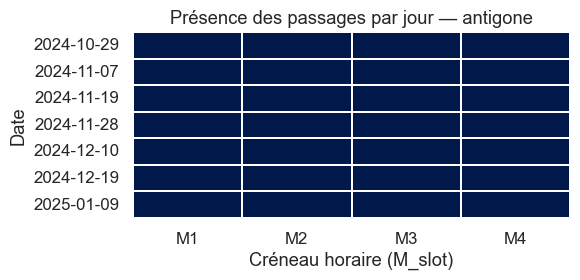

 Heatmap enregistrée : heatmap_passages_boulevards.png


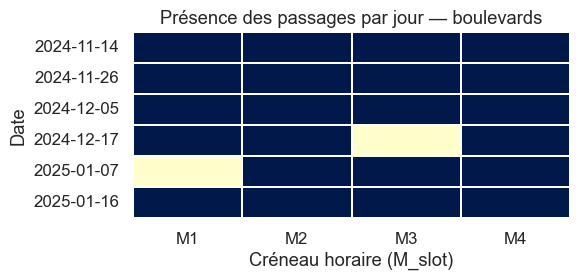

 Heatmap enregistrée : heatmap_passages_ecusson.png


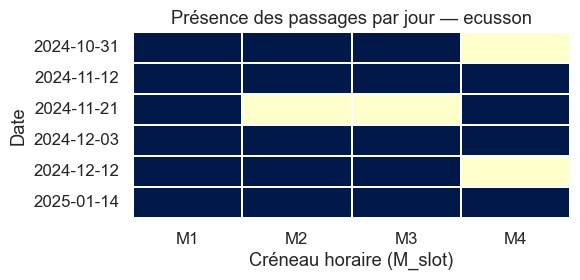

In [86]:
#  Création du dossier de sortie
OUTPUT_DIR = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs/figures/comptage")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

#  Vérification des colonnes nécessaires
required_cols = {"fichier_originaire", "track_id", "date", "M_slot"}
missing_cols = required_cols - set(raw.columns)

# Si certaines colonnes manquent, on les reconstruit depuis le nom du fichier
if missing_cols:
    print(f" Colonnes manquantes détectées : {missing_cols}")
    if "fichier_originaire" not in raw.columns:
        raise ValueError("La colonne 'fichier_originaire' est nécessaire pour extraire les infos manquantes.")
    
    def parse_filename(name):
        """Extrait track_id, date et M_slot depuis le nom du fichier."""
        m = re.search(r"montpellier_(\w+)_(\d{8})_(\d{4})", name)
        if not m:
            return pd.Series([None, None, None])
        track, date_str, time_str = m.groups()
        date = pd.to_datetime(date_str, format="%Y%m%d").date()
        hour = int(time_str[:2])
        if 8 <= hour < 11:
            mslot = "M1"
        elif 11 <= hour < 14:
            mslot = "M2"
        elif 14 <= hour < 17:
            mslot = "M3"
        elif 17 <= hour < 20:
            mslot = "M4"
        else:
            mslot = "UNK"
        return pd.Series([track, date, mslot])

    raw[["track_id", "date", "M_slot"]] = raw.apply(
        lambda row: parse_filename(row["fichier_originaire"]), axis=1
    )

# Force le bon format de date
raw["date"] = pd.to_datetime(raw["date"], errors="coerce").dt.date

# Nombre de créneaux M1–M4 distincts par jour et par parcours
nb_passages = (
    raw.dropna(subset=["track_id", "date", "M_slot"])
       .groupby(["track_id", "date"])
       .agg(nb_M=("M_slot", "nunique"))
       .reset_index()
)

print("Nombre de créneaux M1–M4 par jour et par parcours :")
display(nb_passages.head(10))

# Résumé global
nb_passages_summary = (
    nb_passages.groupby("track_id")["nb_M"]
               .value_counts()
               .unstack(fill_value=0)
               .sort_index(axis=1)
)

print("\nRépartition du nombre de passages par jour :")
display(nb_passages_summary)

#  Heatmap binaire de présence par jour et M_slot
for track in sorted(raw["track_id"].dropna().unique()):
    df_t = (
        raw.query("track_id == @track")
           .dropna(subset=["date", "M_slot"])
           .groupby(["date", "M_slot"])
           .size()
           .unstack(fill_value=0)
           .reindex(columns=["M1", "M2", "M3", "M4"])
    )

    # Heatmap 
    plt.figure(figsize=(6, max(3, len(df_t) * 0.3)))
    sns.heatmap(
        (df_t > 0).astype(int),             
        cmap=["#FFFFCC", "#00194A"],       
        cbar=False,
        linewidths=0.2,
        linecolor="white",
        vmin=0, vmax=1
    )
    plt.title(f"Présence des passages par jour — {track}")
    plt.xlabel("Créneau horaire (M_slot)")
    plt.ylabel("Date")
    plt.tight_layout()

    # Sauvegarde dans le dossier comptage 
    out_path = OUTPUT_DIR / f"heatmap_passages_{track}.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    print(f" Heatmap enregistrée : {out_path.name}")

    plt.show()

## l’étape 3.3 — Agrégation par passage.

In [87]:
# Répertoire contenant les fichiers à agréger
DATA_DIR = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs/clean_nozeros")

# Liste des fichiers CSV à inclure (sauf celui à exclure)
paths = [
    p for p in DATA_DIR.glob("*.csv")
    if "picopatt_montpellier_ecusson_20250114_0832_clean.csv" not in p.name
]

print(f"Fichiers pris en compte ({len(paths)}):")
for p in paths:
    print("  -", p.name)

# Lecture et concaténation des fichiers
frames = []
for p in paths:
    df = pd.read_csv(p)
    df["source_file"] = p.name
    frames.append(df)

if not frames:
    raise ValueError("Aucun fichier n’a été trouvé pour l’agrégation.")

raw = pd.concat(frames, ignore_index=True, sort=False)
print(f"\nDonnées combinées : {raw.shape[0]} lignes, {raw.shape[1]} colonnes.")

# Définition des variables météo
METEO_VARS = [
    "tair_thermohygro", "tair_tc1", "tair_tc2", "tair_anemo",
    "rh_thermohygro", "ws", "wdir",
    "sw_up", "sw_front", "sw_right",
    "lw_up", "lw_down", "lw_front", "lw_back", "lw_left", "lw_right",
    "tmrt", "pet"
]

# Vérifie que les colonnes existent bien
METEO_VARS = [v for v in METEO_VARS if v in raw.columns]
if not METEO_VARS:
    raise ValueError("Aucune variable météo trouvée dans les fichiers.")

print(f"\nVariables météo utilisées ({len(METEO_VARS)}) : {METEO_VARS}")

# Agrégation par parcours, date et créneau horaire 
agg_passage = (
    raw.dropna(subset=["track_id", "date", "M_slot"])
       .groupby(["track_id", "date", "M_slot"])[METEO_VARS]
       .agg(["mean", "std", "min", "max"])
)

# Renommage clair des colonnes
agg_passage.columns = [f"{col}_{stat}" for col, stat in agg_passage.columns]
agg_passage = agg_passage.reset_index()

# Sauvegarde
AGG_DIR = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs/aggregations")
AGG_DIR.mkdir(parents=True, exist_ok=True)

output_file = AGG_DIR / "agg_par_passage.csv"
agg_passage.to_csv(output_file, index=False)

# Résumé
print(f"\nFichier sauvegardé : {output_file}")
print(f"Taille du tableau agrégé : {agg_passage.shape}")
print("\nExtrait des 5 premières lignes :")
display(agg_passage.head())

print("\nNombre de combinaisons uniques (track_id, date, M_slot) :",
      agg_passage[['track_id', 'date', 'M_slot']].drop_duplicates().shape[0])

Fichiers pris en compte (70):
  - picopatt_montpellier_boulevards_20241205_0822.csv
  - picopatt_montpellier_antigone_20241119_1127.csv
  - picopatt_montpellier_antigone_20241107_1429.csv
  - picopatt_montpellier_ecusson_20241112_1430.csv
  - picopatt_montpellier_ecusson_20241121_0832.csv
  - picopatt_montpellier_antigone_20241128_1728.csv
  - picopatt_montpellier_boulevards_20241114_1429.csv
  - picopatt_montpellier_antigone_20241210_0841.csv
  - picopatt_montpellier_boulevards_20241217_1128.csv
  - picopatt_montpellier_ecusson_20241203_0829.csv
  - picopatt_montpellier_boulevards_20241205_1124.csv
  - picopatt_montpellier_antigone_20241119_1724.csv
  - picopatt_montpellier_ecusson_20241203_1128.csv
  - picopatt_montpellier_antigone_20241029_1423.csv
  - picopatt_montpellier_antigone_20241210_1427.csv
  - picopatt_montpellier_antigone_20250109_1429.csv
  - picopatt_montpellier_boulevards_20241205_1430.csv
  - picopatt_montpellier_antigone_20241210_1130.csv
  - picopatt_montpellier_ant

track_id        date M_slot  tair_thermohygro_mean  tair_thermohygro_std  \
0  antigone  2024-10-29     M1              17.516587              0.542930   
1  antigone  2024-10-29     M2              21.925299              0.824948   
2  antigone  2024-10-29     M3              22.721824              0.727495   
3  antigone  2024-10-29     M4              18.949057              0.728786   
4  antigone  2024-11-07     M1              15.404209              0.644458   

   tair_thermohygro_min  tair_thermohygro_max  tair_tc1_mean  tair_tc1_std  \
0             16.460288             18.270771      17.452094      0.542280   
1             20.204089             23.627451      22.056872      1.152194   
2             21.507210             24.433890      22.598243      0.993123   
3             17.581827             20.321584      18.754260      0.677225   
4             14.505608             16.641871      15.355163      0.690814   

   tair_tc1_min  ...  lw_right_min  lw_right_max  tmrt_mean   tmrt_std  \
0     16.281250  ...    401.862803    434.930791  25.449064   2.777669   
1     19.859375  ...    407.761914    491.480420  39.785338  13.723515   
2     20.781250  ...    416.630442    490.942975  34.512903  11.645090   
3     17.210938  ...    399.997667    453.026923  21.286374   1.358106   
4     14.296875  ...    391.255297    425.863401  24.294307   4.633440   

    tmrt_min   tmrt_max   pet_mean   pet_std    pet_min    pet_max  
0  21.675006  34.860582  17.241758  2.211648  12.994762  27.738736  
1  23.056350  73.053752  26.309738  7.149277  16.540380  55.898584  
2  24.019766  66.289134  24.991883  5.550945  18.332925  47.077139  
3  18.196471  24.099809  17.229509  1.303172  13.766295  22.737194  
4  18.281736  52.616889  14.879950  2.817454  10.463749  34.800722  

[5 rows x 75 columns]


Nombre de combinaisons uniques (track_id, date, M_slot) : 70


## l’étape 3.3 — Agrégation par passage (fichier exclu)

In [77]:
# Dossier des fichiers propres
DATA_DIR = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs/clean_nozeros")

# Liste des fichiers à inclure (exclut le fichier fautif) 
paths = [
    p for p in DATA_DIR.glob("*.csv")
    if "picopatt_montpellier_ecusson_20250114_0832.csv" not in p.name
]

print(f"{len(paths)} fichiers détectés (le fichier fautif est exclu).")
for p in paths:
    print("  -", p.name)

# Lecture et concaténation
frames = []
for p in paths:
    try:
        df = pd.read_csv(p, sep=None, engine="python")
        df["fichier_originaire"] = p.name
        frames.append(df)
    except Exception as e:
        print(f" Erreur lecture {p.name}: {e}")

if not frames:
    raise ValueError("Aucun fichier valide trouvé dans le dossier !")

raw_filtered = pd.concat(frames, ignore_index=True, sort=False)
print(f"\nDonnées combinées : {raw_filtered.shape[0]} lignes, {raw_filtered.shape[1]} colonnes.\n")

# Définition des variables météo 
METEO_VARS = [
    "tair_thermohygro", "tair_tc1", "tair_tc2", "tair_anemo",
    "rh_thermohygro", "ws", "wdir",
    "sw_up", "sw_front", "sw_right",
    "lw_up", "lw_down", "lw_front", "lw_back", "lw_left", "lw_right",
    "tmrt", "pet"
]
METEO_VARS = [v for v in METEO_VARS if v in raw_filtered.columns]
print(f" Variables utilisées ({len(METEO_VARS)}): {METEO_VARS}")

# Agrégation
agg_passage_clean = (
    raw_filtered.dropna(subset=["track_id", "date", "M_slot"])
                .groupby(["track_id", "date", "M_slot"])[METEO_VARS]
                .agg(["mean", "std", "min", "max"])
)
agg_passage_clean.columns = [f"{col}_{stat}" for col, stat in agg_passage_clean.columns]
agg_passage_clean = agg_passage_clean.reset_index()

# Sauvegarde
AGG_DIR = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs/aggregations")
AGG_DIR.mkdir(parents=True, exist_ok=True)

output_file = AGG_DIR / "agg_par_passage_clean_no_ecusson0832.csv"
agg_passage_clean.to_csv(output_file, index=False)

print(f"Fichier agrégé créé : {output_file}")
print(f"Taille du tableau : {agg_passage_clean.shape}")

70 fichiers détectés (le fichier fautif est exclu).
  - picopatt_montpellier_boulevards_20241205_0822.csv
  - picopatt_montpellier_antigone_20241119_1127.csv
  - picopatt_montpellier_antigone_20241107_1429.csv
  - picopatt_montpellier_ecusson_20241112_1430.csv
  - picopatt_montpellier_ecusson_20241121_0832.csv
  - picopatt_montpellier_antigone_20241128_1728.csv
  - picopatt_montpellier_boulevards_20241114_1429.csv
  - picopatt_montpellier_antigone_20241210_0841.csv
  - picopatt_montpellier_boulevards_20241217_1128.csv
  - picopatt_montpellier_ecusson_20241203_0829.csv
  - picopatt_montpellier_boulevards_20241205_1124.csv
  - picopatt_montpellier_ecusson_20250114_0832_clean.csv
  - picopatt_montpellier_antigone_20241119_1724.csv
  - picopatt_montpellier_ecusson_20241203_1128.csv
  - picopatt_montpellier_antigone_20241029_1423.csv
  - picopatt_montpellier_antigone_20241210_1427.csv
  - picopatt_montpellier_antigone_20250109_1429.csv
  - picopatt_montpellier_boulevards_20241205_1430.csv
 

## M_slot valide 

In [78]:
# Vérifie que la colonne existe
if "M_slot" not in raw.columns:
    raise ValueError(" La colonne 'M_slot' est absente du DataFrame. Vérifie ton chargement de données.")

# Détection des valeurs manquantes ou inconnues
mask_missing = raw["M_slot"].isna() | (raw["M_slot"] == "UNK")
total_missing = mask_missing.sum()
print(f"Total de lignes sans M_slot valide : {total_missing:,}")

if total_missing > 0:
    # Regroupement par fichier pour identifier les sources problématiques
    missing_by_file = (
        raw.loc[mask_missing]
           .groupby("fichier_originaire", dropna=False)
           .size()
           .sort_values(ascending=False)
           .rename("nb_lignes_sans_Mslot")
           .reset_index()
    )

    print("\n Fichiers contenant des lignes sans M_slot ou 'UNK' :")
    display(missing_by_file.head(20))

    # Correction automatique à partir du nom du fichier
    def infer_mslot_from_filename(filename):
        """Déduit M_slot selon l'heure contenue dans le nom du fichier."""
        m = re.search(r"_(\d{8})_(\d{4})", str(filename))
        if not m:
            return None
        _, time_str = m.groups()
        hour = int(time_str[:2])
        if 8 <= hour < 11:
            return "M1"
        elif 11 <= hour < 14:
            return "M2"
        elif 14 <= hour < 17:
            return "M3"
        elif 17 <= hour < 20:
            return "M4"
        else:
            return None

    # Correction sur les lignes concernées
    raw.loc[mask_missing, "M_slot"] = raw.loc[mask_missing, "fichier_originaire"].apply(infer_mslot_from_filename)

    # Vérifie le résultat après correction
    mask_missing_after = raw["M_slot"].isna() | (raw["M_slot"] == "UNK")
    remaining = mask_missing_after.sum()
    print(f"\n Correction effectuée. Lignes restantes sans M_slot valide : {remaining:,}")

    # Détail si certaines lignes n'ont toujours pas pu être corrigées
    if remaining > 0:
        print("\nLignes non corrigées (fichiers non reconnus) :")
        display(raw.loc[mask_missing_after, ["fichier_originaire", "M_slot"]].drop_duplicates())
else:
    print(" Aucun M_slot manquant ni 'UNK' détecté !")
    #  Affiche un échantillon des lignes qui ont été corrigées

    
mask_corr = raw["fichier_originaire"].str.contains("boulevards_20241114_1728", na=False)
display(raw.loc[mask_corr, ["fichier_originaire", "timestamp", "M_slot"]].head(10))

Total de lignes sans M_slot valide : 0
 Aucun M_slot manquant ni 'UNK' détecté !


fichier_originaire            timestamp  \
89400  picopatt_montpellier_boulevards_20241114_1728.csv  2024-11-14 17:30:21   
89401  picopatt_montpellier_boulevards_20241114_1728.csv  2024-11-14 17:30:22   
89402  picopatt_montpellier_boulevards_20241114_1728.csv  2024-11-14 17:30:23   
89403  picopatt_montpellier_boulevards_20241114_1728.csv  2024-11-14 17:30:24   
89404  picopatt_montpellier_boulevards_20241114_1728.csv  2024-11-14 17:30:25   
89405  picopatt_montpellier_boulevards_20241114_1728.csv  2024-11-14 17:30:26   
89406  picopatt_montpellier_boulevards_20241114_1728.csv  2024-11-14 17:30:27   
89407  picopatt_montpellier_boulevards_20241114_1728.csv  2024-11-14 17:30:28   
89408  picopatt_montpellier_boulevards_20241114_1728.csv  2024-11-14 17:30:29   
89409  picopatt_montpellier_boulevards_20241114_1728.csv  2024-11-14 17:30:30   

      M_slot  
89400     M4  
89401     M4  
89402     M4  
89403     M4  
89404     M4  
89405     M4  
89406     M4  
89407     M4  
89408     M4  
89409     M4

##  Vérification finale des 0 et NaN dans clean_nozeros

In [88]:

DATA_NOZERO = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs/clean_nozeros")
REPORT_DIR = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs/reports")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# Lecture sûre des fichiers 
def read_any(p: Path) -> pd.DataFrame:
    """Lit un fichier CSV ou Excel, en détectant automatiquement le séparateur."""
    try:
        if p.suffix.lower() in (".xlsx", ".xls"):
            df = pd.read_excel(p)
        else:
            df = pd.read_csv(p, sep=None, engine="python")
        df["__source_file"] = p.name
        return df
    except Exception as e:
        print(f"Erreur lecture {p.name}: {e}")
        return pd.DataFrame()

# Fusion de tous les fichiers
def load_all(data_dir: Path) -> pd.DataFrame:
    """Charge et fusionne tous les fichiers du dossier."""
    paths = sorted([p for p in data_dir.rglob("*") if p.suffix.lower() in (".csv", ".xlsx", ".xls")])
    if not paths:
        raise FileNotFoundError(f"Aucun fichier trouvé dans {data_dir.resolve()}")

    frames = [read_any(p) for p in paths if not read_any(p).empty]
    if not frames:
        raise ValueError("Aucun fichier lisible trouvé dans le dossier.")
    return pd.concat(frames, ignore_index=True, sort=False)

# Chargement
raw_nozero = load_all(DATA_NOZERO)
print(f"Données chargées : {len(raw_nozero):,} lignes, {len(raw_nozero.columns)} colonnes")

# Sélection des colonnes numériques
numeric_cols = raw_nozero.select_dtypes(include=[np.number]).columns
if numeric_cols.empty:
    raise ValueError("Aucune colonne numérique trouvée dans les fichiers !")

# Comptage des 0 et des NaN
zero_counts = (raw_nozero[numeric_cols] == 0).sum()
nan_counts = raw_nozero[numeric_cols].isna().sum()

# Calcul des pourcentages
total = len(raw_nozero)
zero_pct = (zero_counts / total * 100).round(2)
nan_pct = (nan_counts / total * 100).round(2)

# Assemblage du rapport
report = (
    pd.DataFrame({
        "nb_zeros": zero_counts,
        "pct_zeros": zero_pct,
        "nb_nans": nan_counts,
        "pct_nans": nan_pct
    })
    .query("nb_zeros > 0 or nb_nans > 0")
    .sort_values(by=["pct_zeros", "pct_nans"], ascending=False)
)

# Affichage
if report.empty:
    print(" Aucune variable ne contient de 0 ni de NaN !")
else:
    print("\nVariables contenant encore des 0 ou des NaN :")
    display(report.head(30))
    print(f"\n{report.shape[0]} variables concernées sur {len(numeric_cols)} colonnes numériques.")

# Sauvegarde du rapport
report_path = REPORT_DIR / "zero_nan_report.csv"
report.to_csv(report_path, index=True)
print(f"\nRapport sauvegardé dans : {report_path}")
print(f"Taille totale du dataset : {total:,} lignes")

Données chargées : 339,264 lignes, 40 colonnes

Variables contenant encore des 0 ou des NaN :


nb_zeros  pct_zeros  nb_nans  pct_nans
wdir                  1848       0.54        0      0.00
section_duration         0       0.00   335599     98.92
section_speed            0       0.00   335599     98.92
sw_up                    0       0.00    87033     25.65
tair_tc2                 0       0.00     7504      2.21
tair_tc1                 0       0.00     5493      1.62
sw_back                  0       0.00     1328      0.39
ws                       0       0.00      294      0.09
gnss_accuracy            0       0.00        1      0.00
lon_rtk                  0       0.00        1      0.00
lat_rtk                  0       0.00        1      0.00


11 variables concernées sur 31 colonnes numériques.

Rapport sauvegardé dans : /Users/akkouh/Desktop/TER-Picopatt/outputs/reports/zero_nan_report.csv
Taille totale du dataset : 339,264 lignes


## lecture du fichier 

In [89]:
# Lecture du fichier agrégé
agg_file = Path("outputs/aggregations/agg_par_passage.csv")
agg = pd.read_csv(agg_file)

print(f" Données chargées : {len(agg):,} lignes, {len(agg.columns)} colonnes")

# Liste des variables météo (moyennes uniquement)
METEO_VARS = [
    "tair_thermohygro_mean", "tair_tc1_mean", "tair_tc2_mean", "tair_anemo_mean",
    "rh_thermohygro_mean", "ws_mean", "wdir_mean",
    "sw_up_mean", "sw_front_mean", "sw_right_mean",
    "lw_up_mean", "lw_down_mean", "lw_front_mean", "lw_back_mean", "lw_left_mean", "lw_right_mean",
    "tmrt_mean", "pet_mean"
]
METEO_VARS = [v for v in METEO_VARS if v in agg.columns]
print(f"Variables trouvées : {METEO_VARS}")

 Données chargées : 70 lignes, 75 colonnes
Variables trouvées : ['tair_thermohygro_mean', 'tair_tc1_mean', 'tair_tc2_mean', 'tair_anemo_mean', 'rh_thermohygro_mean', 'ws_mean', 'wdir_mean', 'sw_up_mean', 'sw_front_mean', 'sw_right_mean', 'lw_up_mean', 'lw_down_mean', 'lw_front_mean', 'lw_back_mean', 'lw_left_mean', 'lw_right_mean', 'tmrt_mean', 'pet_mean']


##  Boxplot par capteur — détection visuelle d’anomalies

Ce graphique met en évidence les valeurs extrêmes (comme 533 °C et 112 °C) directement.
C’est la meilleure manière de montrer “attention, ces points sortent complètement du lot”.

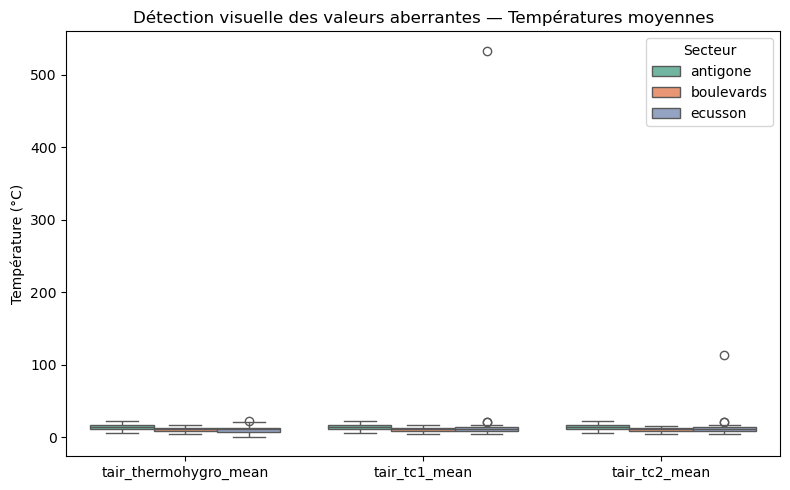

In [56]:
#  Charger le fichier d’agrégation complet 
agg_path = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs/aggregations/agg_par_passage.csv")
agg = pd.read_csv(agg_path)

#  Variables critiques (les capteurs à comparer)
vars_to_plot = ["tair_thermohygro_mean", "tair_tc1_mean", "tair_tc2_mean"]

# Vérification que les colonnes existent dans le fichier
vars_to_plot = [v for v in vars_to_plot if v in agg.columns]
if not vars_to_plot:
    raise ValueError("Aucune des variables demandées n'existe dans le fichier agrégé.")

# Mise en forme 
df_melt = agg.melt(
    id_vars=["track_id"],
    value_vars=vars_to_plot,
    var_name="Capteur",
    value_name="Température"
)

# Graphique boxplot 
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_melt,
    x="Capteur",
    y="Température",
    hue="track_id",
    palette="Set2",
    showfliers=True  # on garde les points aberrants visibles
)
plt.title("Détection visuelle des valeurs aberrantes — Températures moyennes")
plt.ylabel("Température (°C)")
plt.xlabel("")
plt.legend(title="Secteur", loc="upper right")
plt.tight_layout()
plt.show()

##  Boxplot par capteur — détection visuelle apres 

 Colonne 'fichier_originaire' absente — on suppose que les données agrégées ne contiennent plus ce fichier.


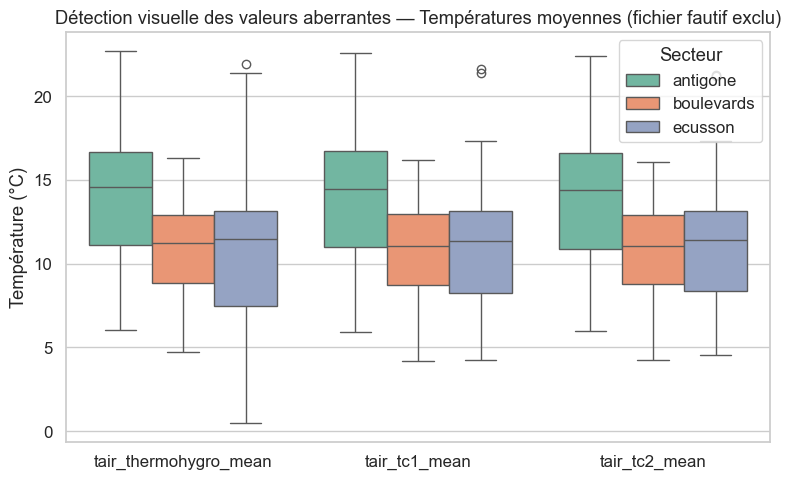

In [90]:
# Charger ton fichier d'agrégation complet 
agg_path = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs/aggregations/agg_par_passage_clean_no_ecusson0832.csv")
agg = pd.read_csv(agg_path)

# Exclure les données issues du fichier fautif (si la colonne existe)
if "fichier_originaire" in agg.columns:
    agg = agg[~agg["fichier_originaire"].str.contains("picopatt_montpellier_ecusson_20250114_0832", case=False, na=False)]
    print("Données du fichier fautif supprimées avant visualisation.")
else:
    print(" Colonne 'fichier_originaire' absente — on suppose que les données agrégées ne contiennent plus ce fichier.")

# Variables critiques (les capteurs à comparer)
vars_to_plot = ["tair_thermohygro_mean", "tair_tc1_mean", "tair_tc2_mean"]

# Vérification de la présence des colonnes
vars_to_plot = [v for v in vars_to_plot if v in agg.columns]
if not vars_to_plot:
    raise ValueError("Aucune variable valide trouvée dans le fichier d'agrégation.")

# Mise en forme (long format)
df_melt = agg.melt(
    id_vars=["track_id"],
    value_vars=vars_to_plot,
    var_name="Capteur",
    value_name="Température"
)

# Graphique boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_melt,
    x="Capteur",
    y="Température",
    hue="track_id",
    palette="Set2",
    showfliers=True
)
plt.title("Détection visuelle des valeurs aberrantes — Températures moyennes (fichier fautif exclu)")
plt.ylabel("Température (°C)")
plt.xlabel("")
plt.legend(title="Secteur", loc="upper right")
plt.tight_layout()
plt.show()

## Scatterplot — Relation Tmrt / PET

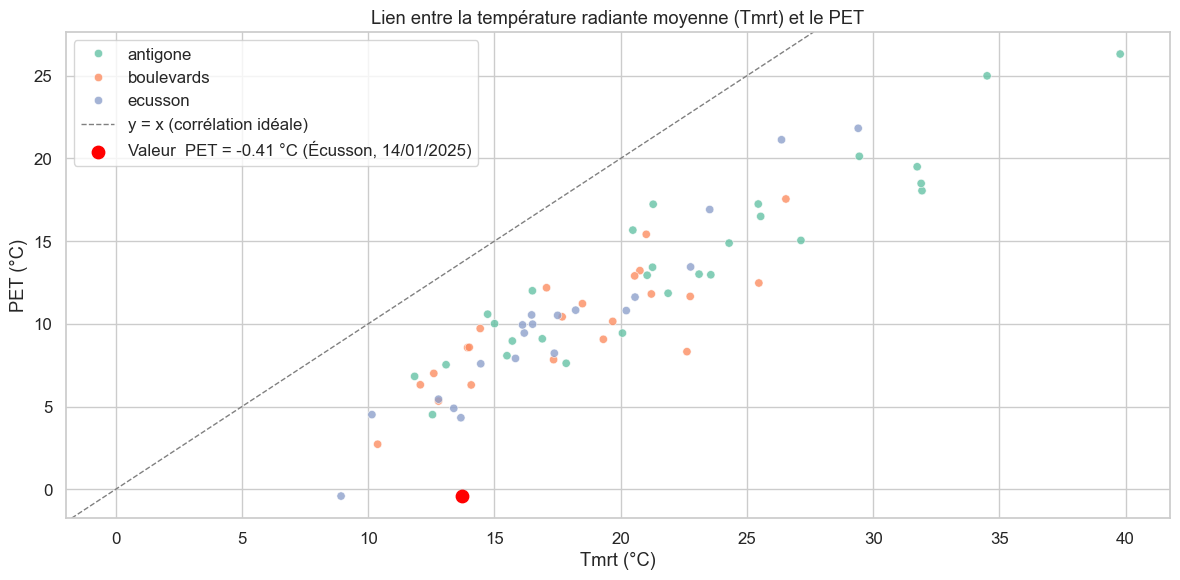

In [91]:

plt.figure(figsize=(12,6))
sns.scatterplot(data=agg, x="tmrt_mean", y="pet_mean", hue="track_id", alpha=0.8, palette="Set2")

# Ligne de référence
plt.axline((0,0), slope=1, color="gray", linestyle="--", lw=1, label="y = x (corrélation idéale)")

# Annotation de la valeur extrême
plt.scatter(13.7, -0.41, color="red", s=80, zorder=5, label="Valeur  PET = -0.41 °C (Écusson, 14/01/2025)")

plt.title("Lien entre la température radiante moyenne (Tmrt) et le PET")
plt.xlabel("Tmrt (°C)")
plt.ylabel("PET (°C)")
plt.legend()
plt.tight_layout()
plt.show()

##   Évolution temporelle par variable — Un seul créneau horaire (M1, M2, M3 ou M4)

Variables disponibles (18): ['tair_thermohygro_mean', 'tair_tc1_mean', 'tair_tc2_mean', 'tair_anemo_mean', 'rh_thermohygro_mean', 'ws_mean', 'wdir_mean', 'sw_up_mean', 'sw_front_mean', 'sw_right_mean', 'lw_up_mean', 'lw_down_mean', 'lw_front_mean', 'lw_back_mean', 'lw_left_mean', 'lw_right_mean', 'tmrt_mean', 'pet_mean']


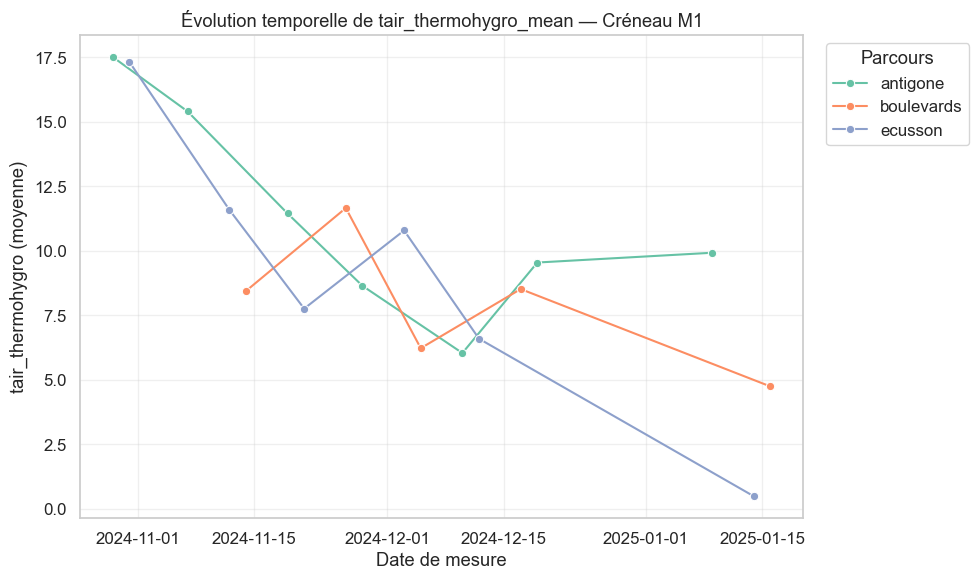

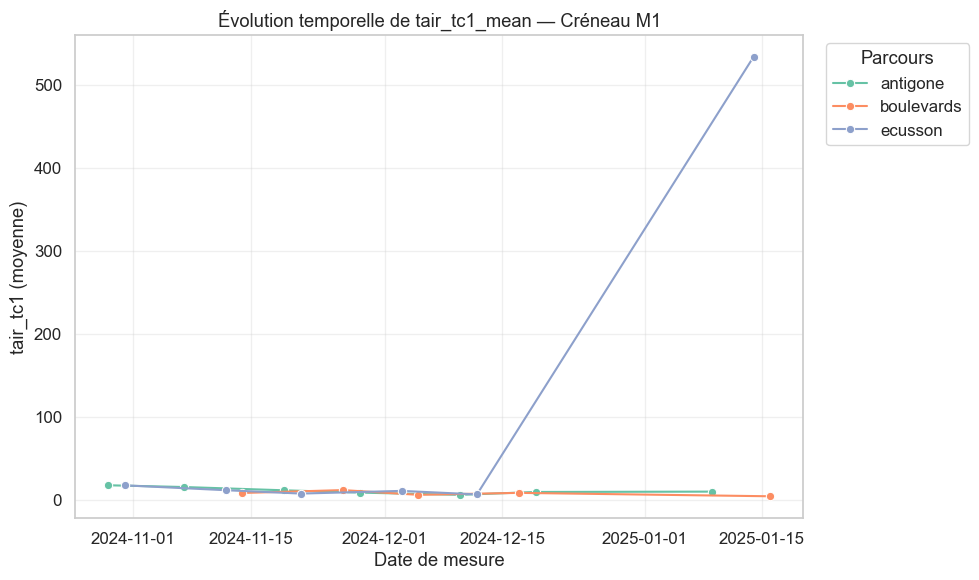

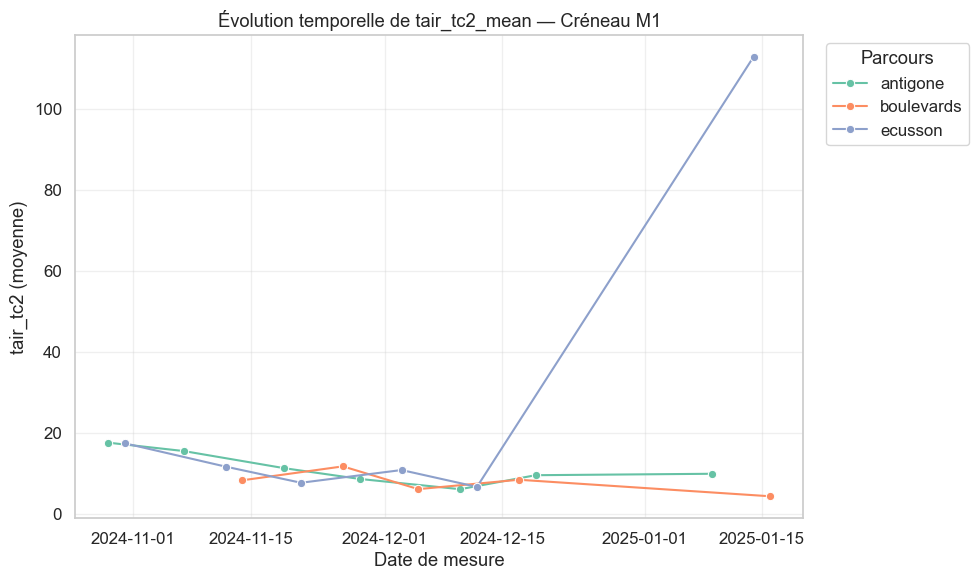

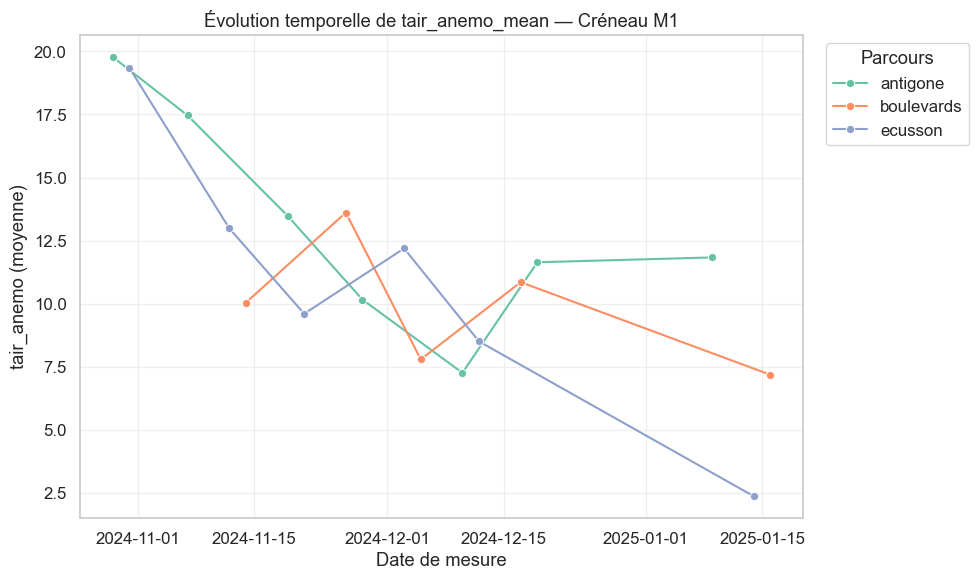

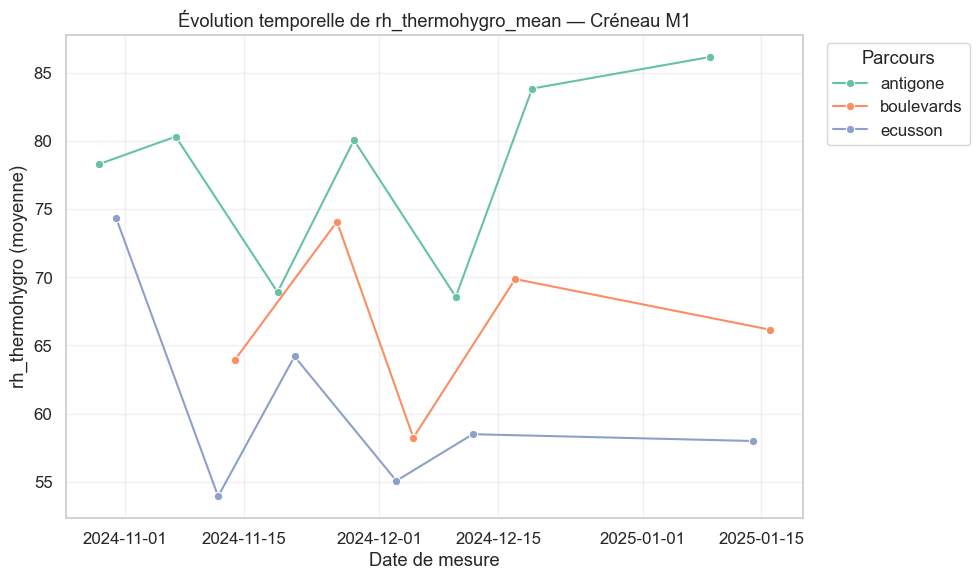

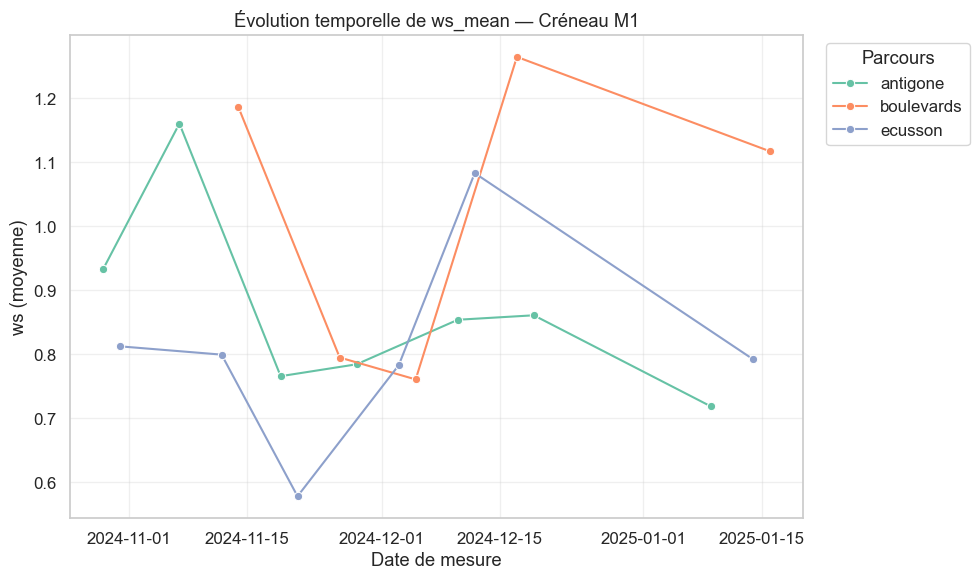

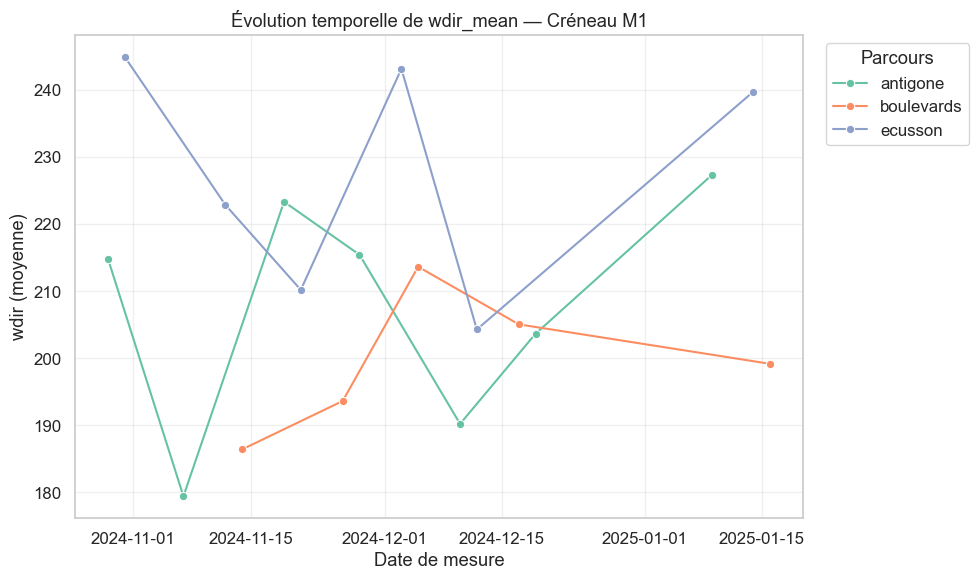

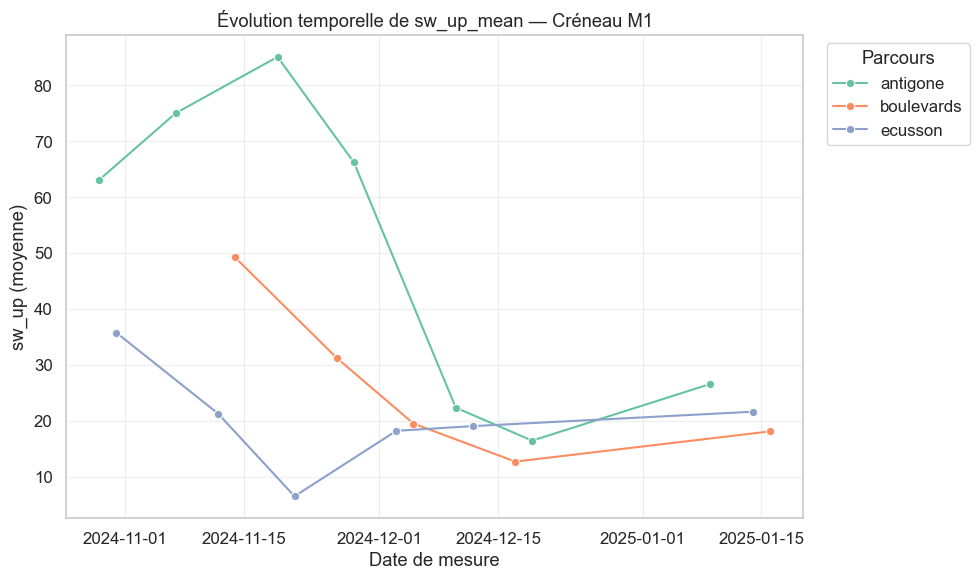

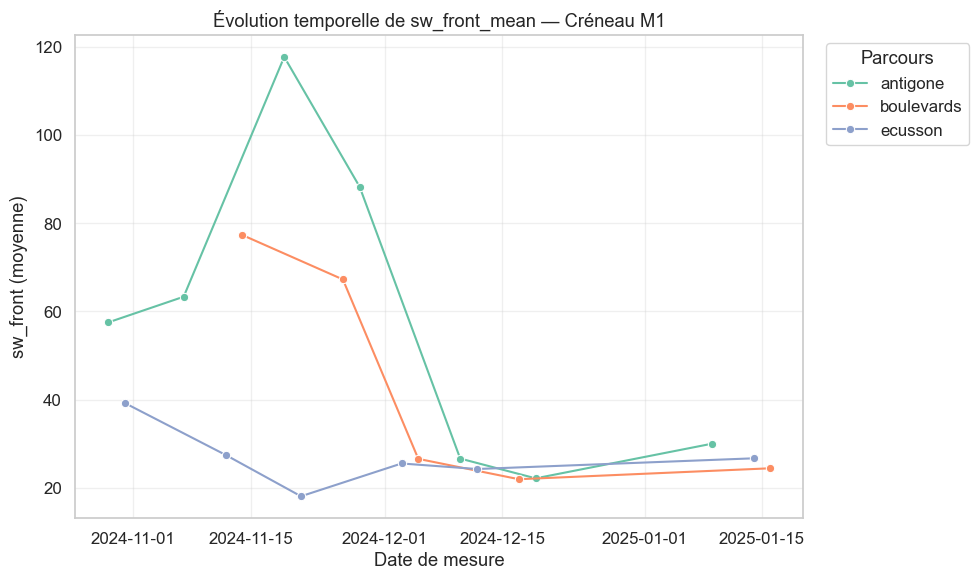

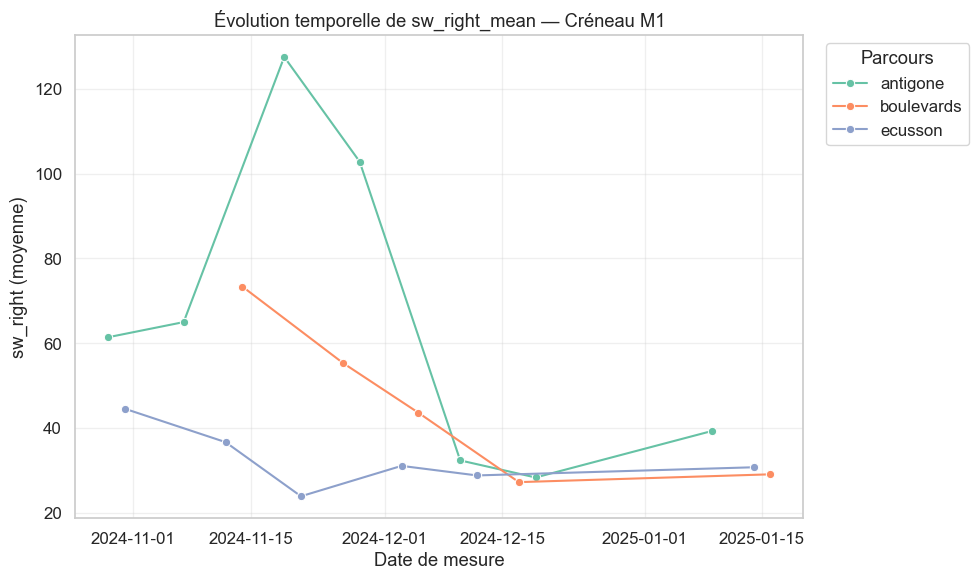

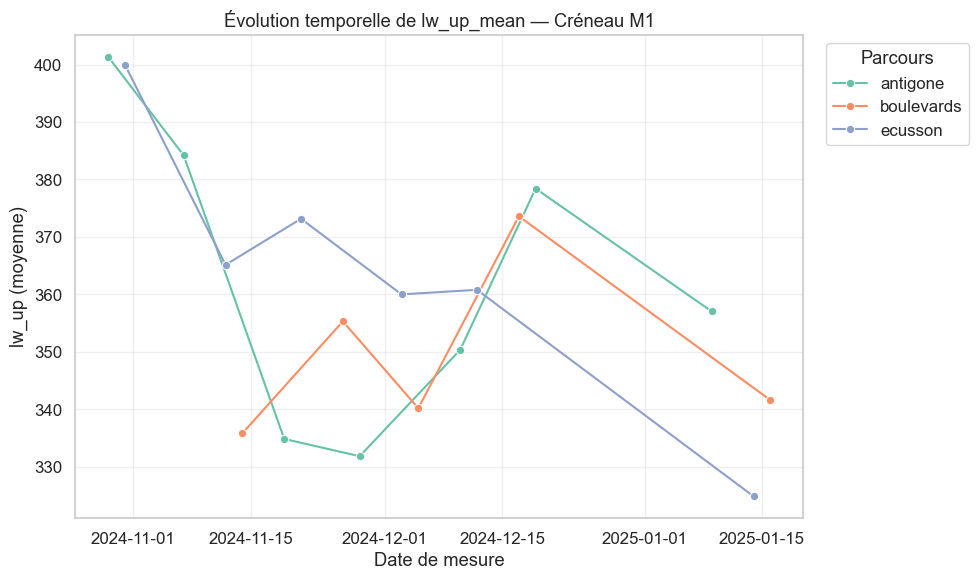

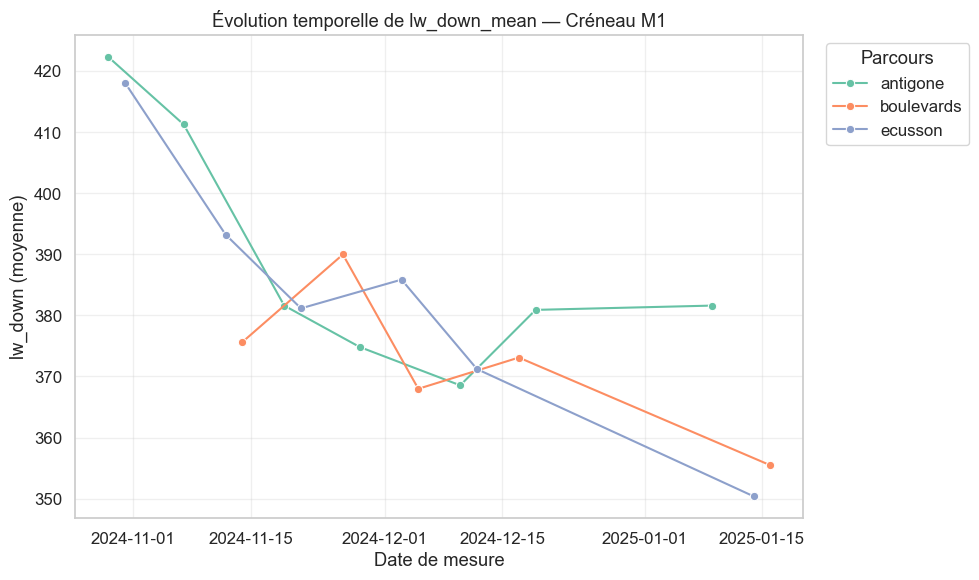

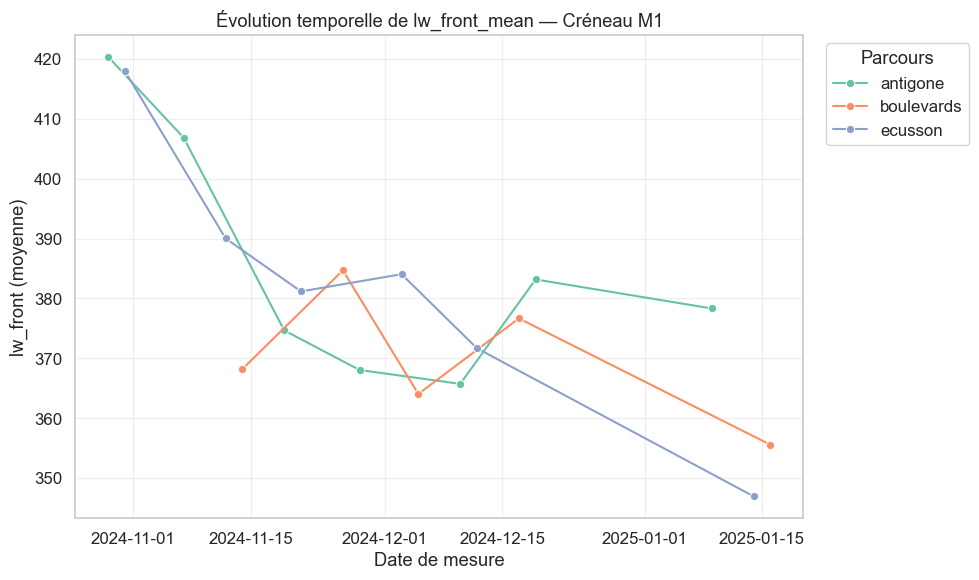

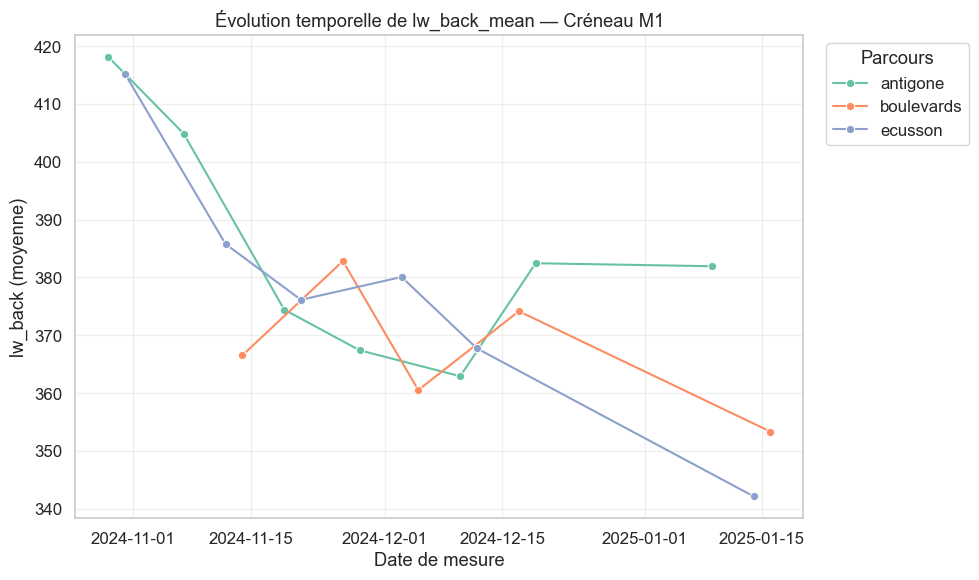

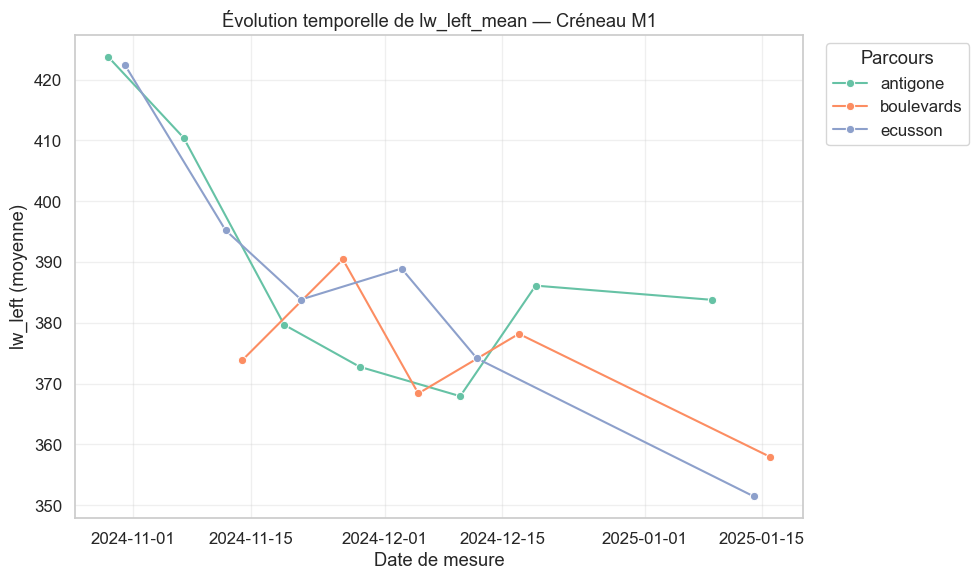

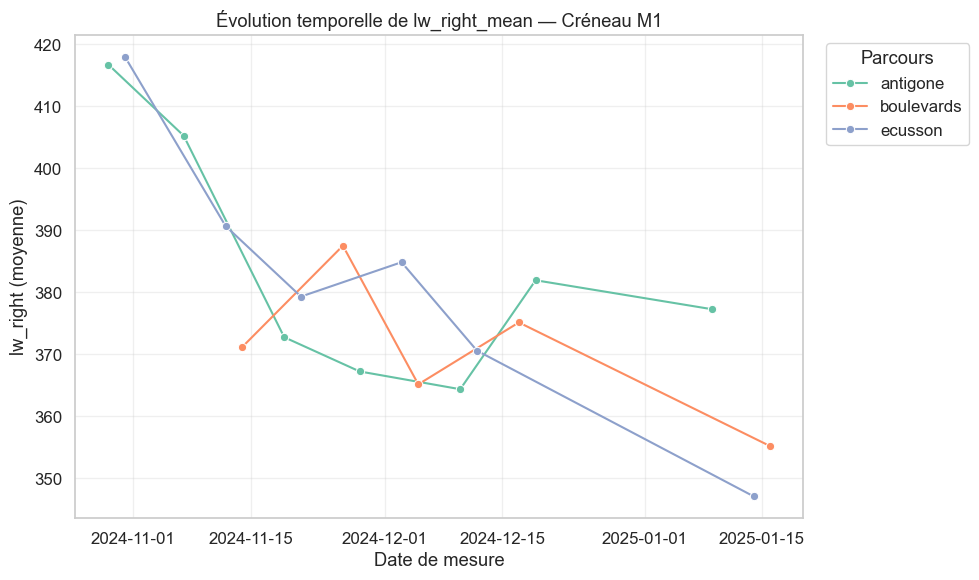

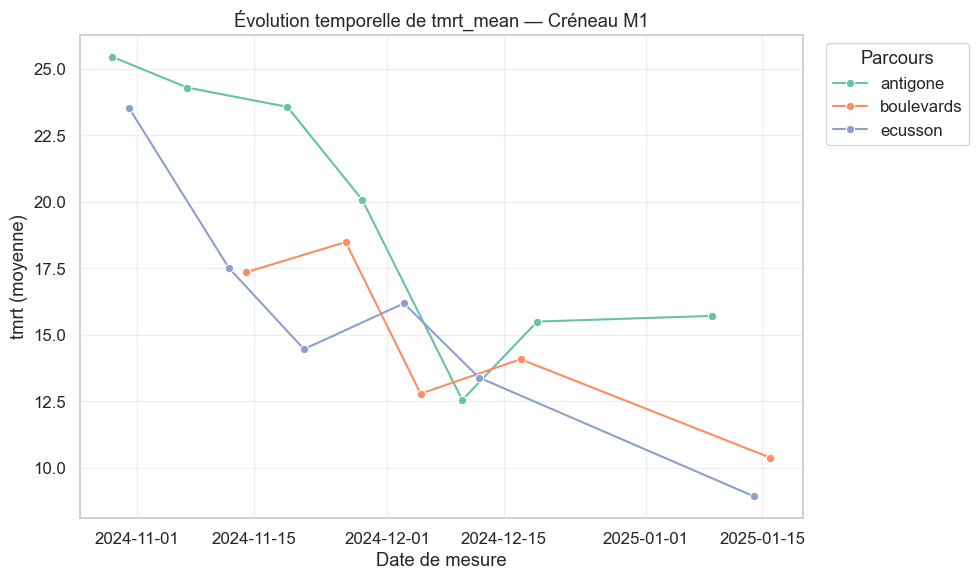

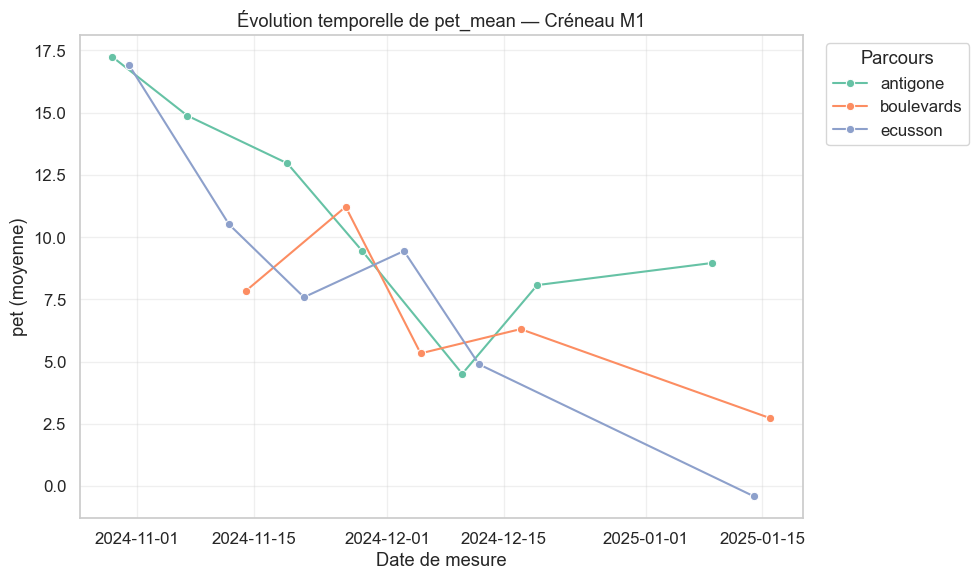

In [62]:


#  Charger le fichier agrégé 
agg_file = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs/aggregations/agg_par_passage.csv")
agg = pd.read_csv(agg_file)

# Convertir la colonne date
agg["date"] = pd.to_datetime(agg["date"], errors="coerce")

# Choisir le créneau horaire à analyser
CRENEAU = "M1" 

# Filtrer uniquement ce créneau
subset = agg.query("M_slot == @CRENEAU")

# Variables à tracer 
vars_to_plot = [
    "tair_thermohygro_mean", "tair_tc1_mean", "tair_tc2_mean", "tair_anemo_mean",
    "rh_thermohygro_mean", "ws_mean", "wdir_mean",
    "sw_up_mean", "sw_front_mean", "sw_right_mean",
    "lw_up_mean", "lw_down_mean", "lw_front_mean", "lw_back_mean", "lw_left_mean", "lw_right_mean",
    "tmrt_mean", "pet_mean"
]

#  Vérifier que les colonnes existent
vars_to_plot = [v for v in vars_to_plot if v in subset.columns]
print(f"Variables disponibles ({len(vars_to_plot)}): {vars_to_plot}")

# Style graphique
sns.set(style="whitegrid", font_scale=1.1)

# Tracé pour chaque variable
for var in vars_to_plot:
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=subset,
        x="date",
        y=var,
        hue="track_id",
        marker="o",
        palette="Set2"
    )
    plt.title(f"Évolution temporelle de {var} — Créneau {CRENEAU}")
    plt.xlabel("Date de mesure")
    plt.ylabel(var.replace("_mean", " (moyenne)"))
    plt.legend(title="Parcours", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

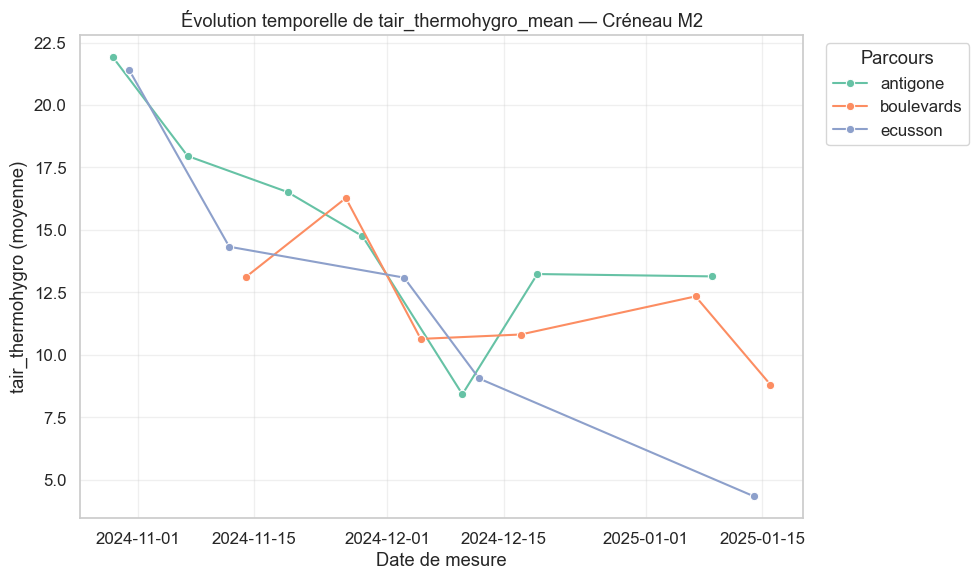

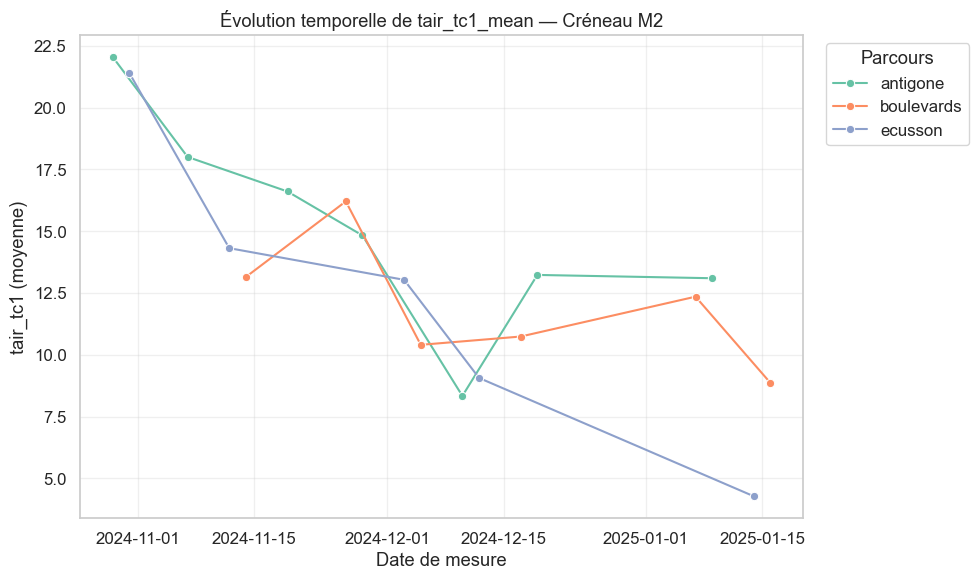

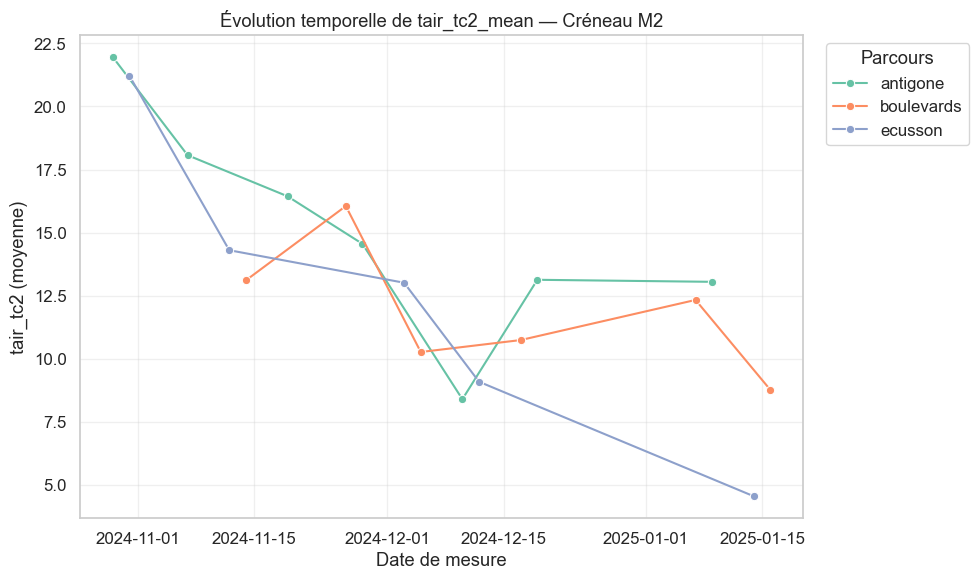

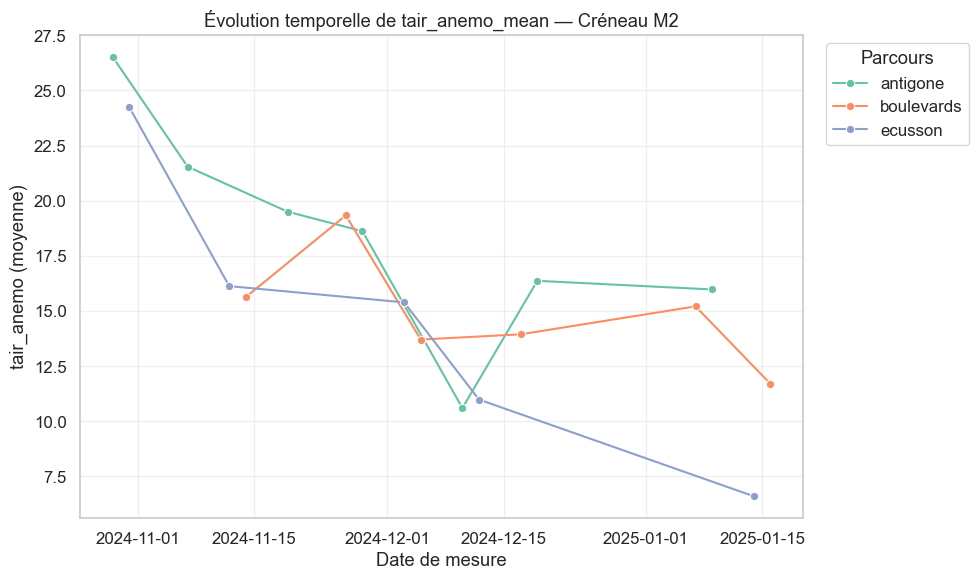

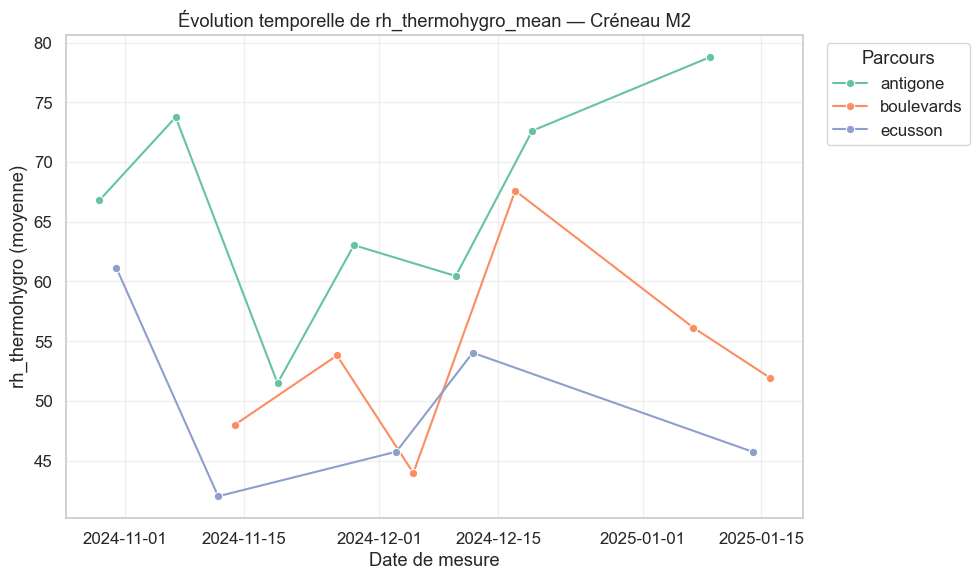

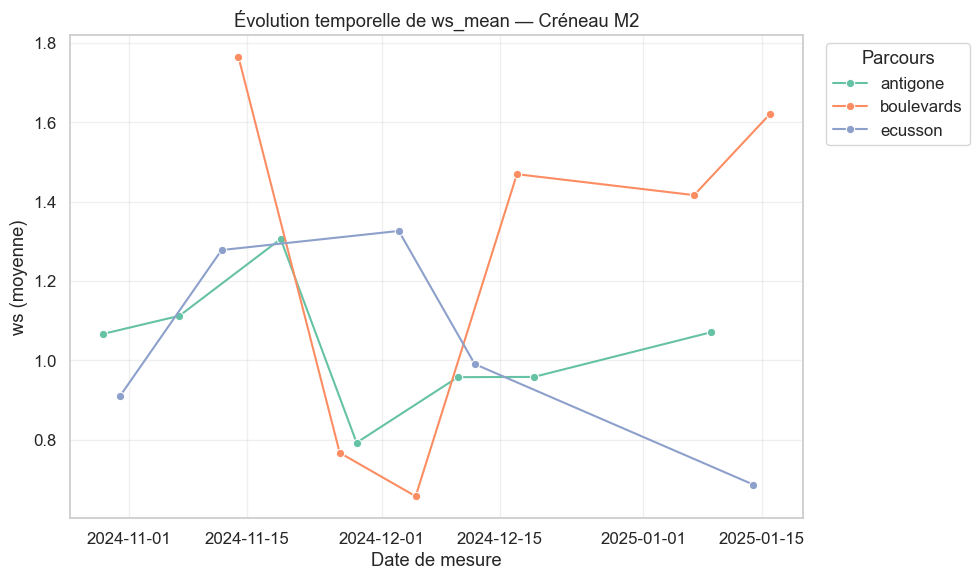

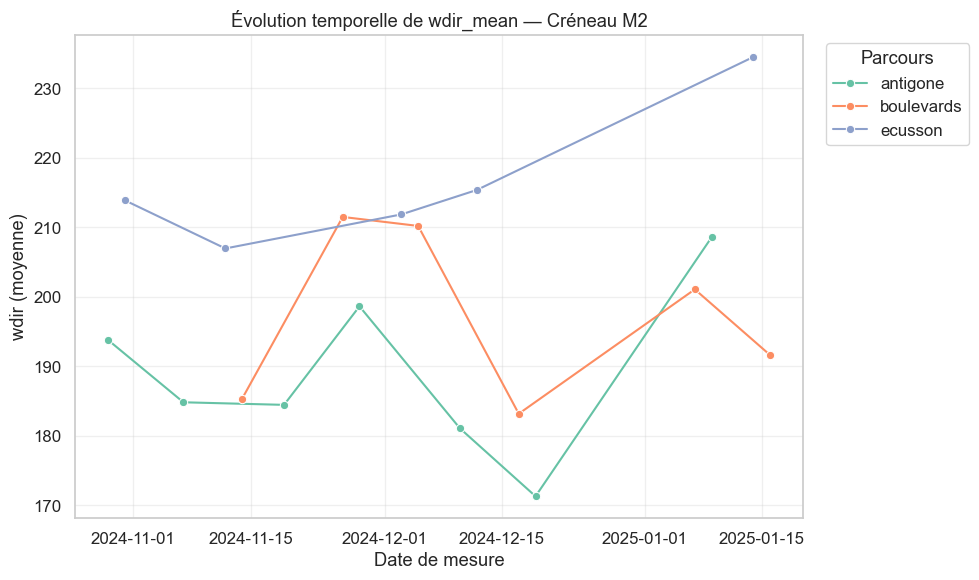

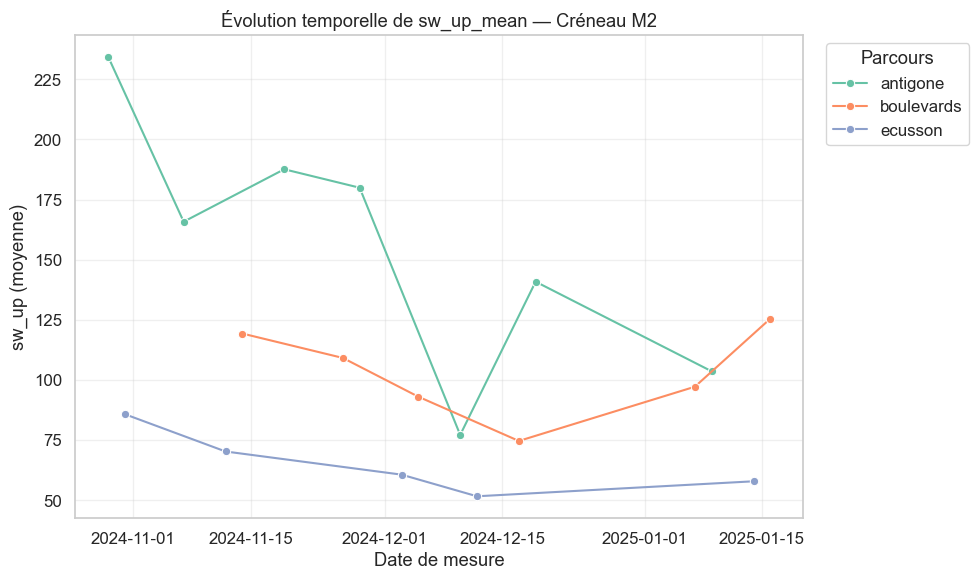

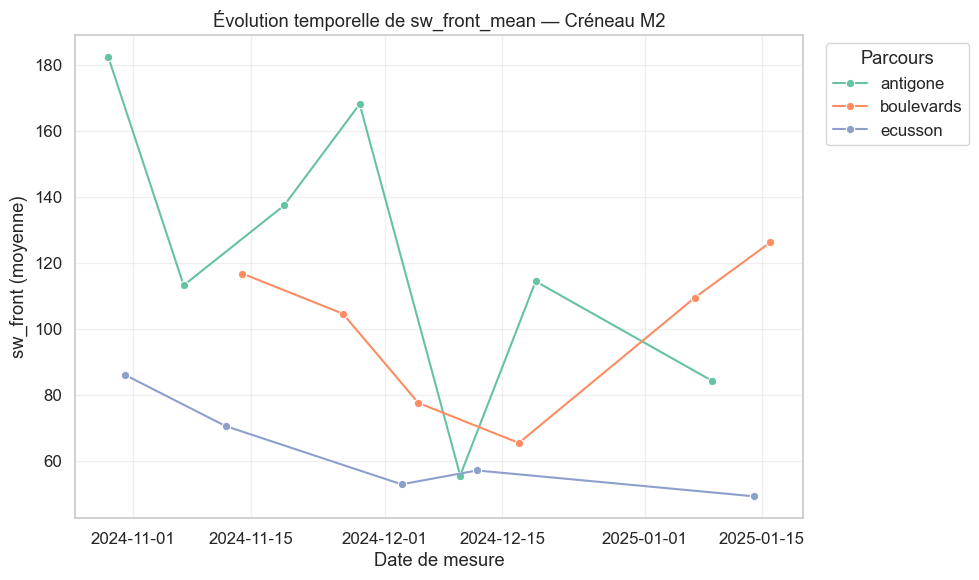

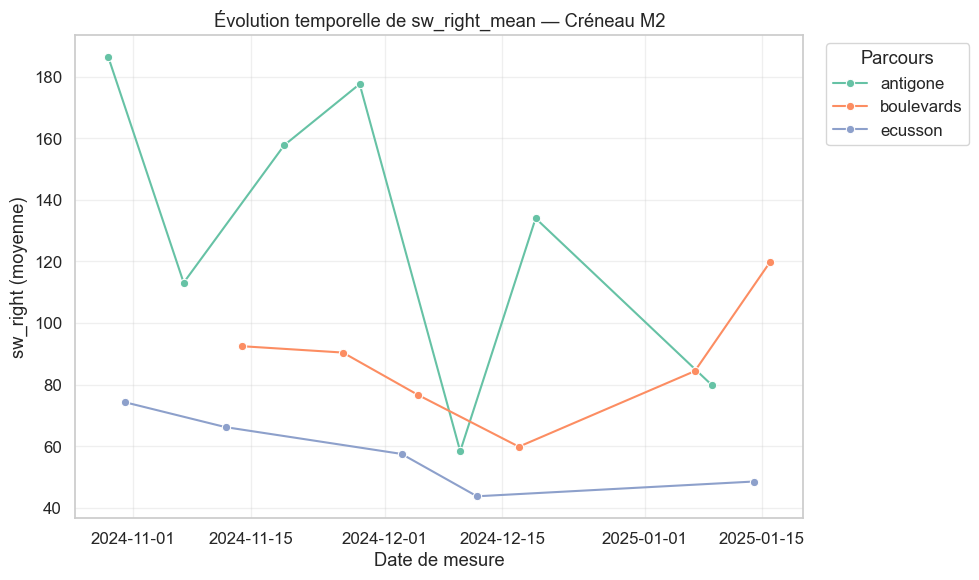

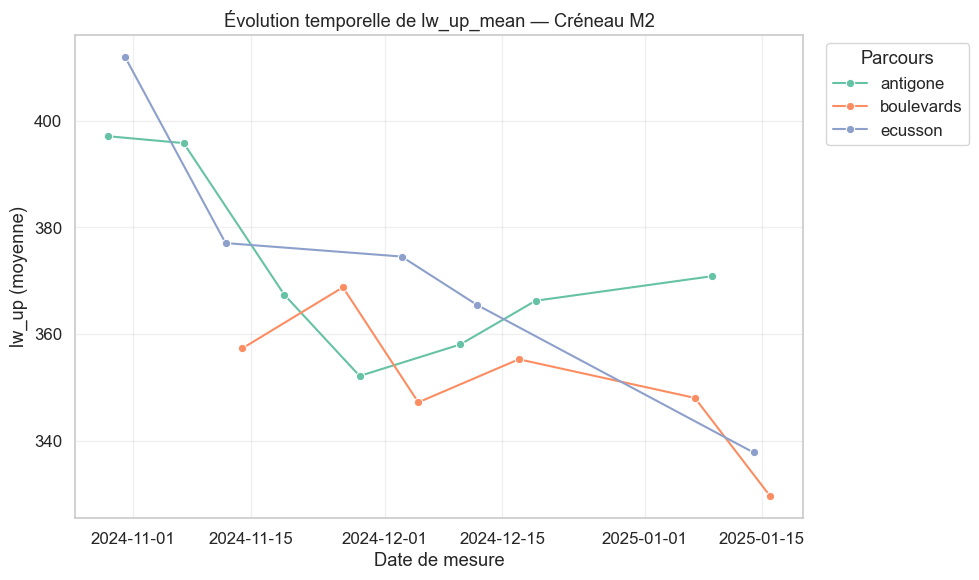

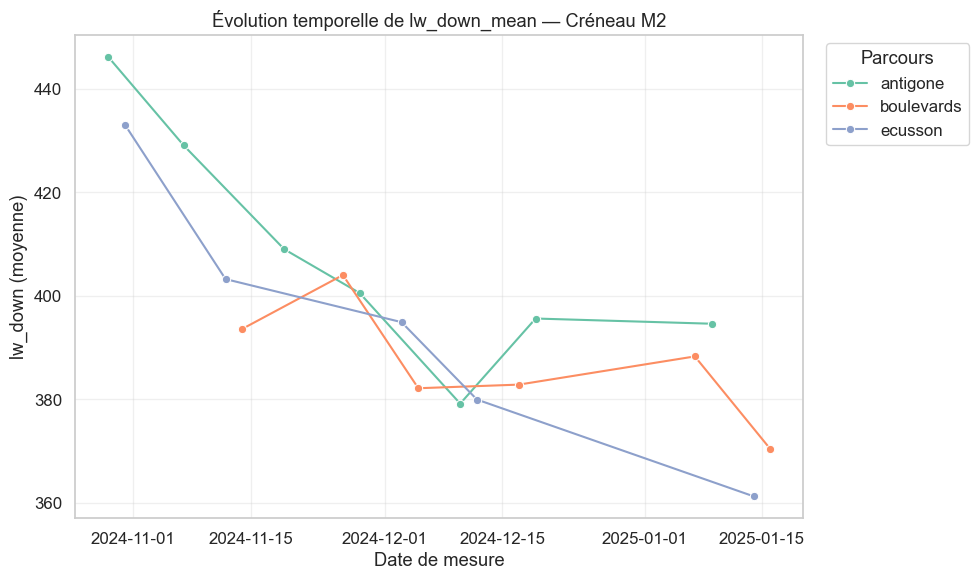

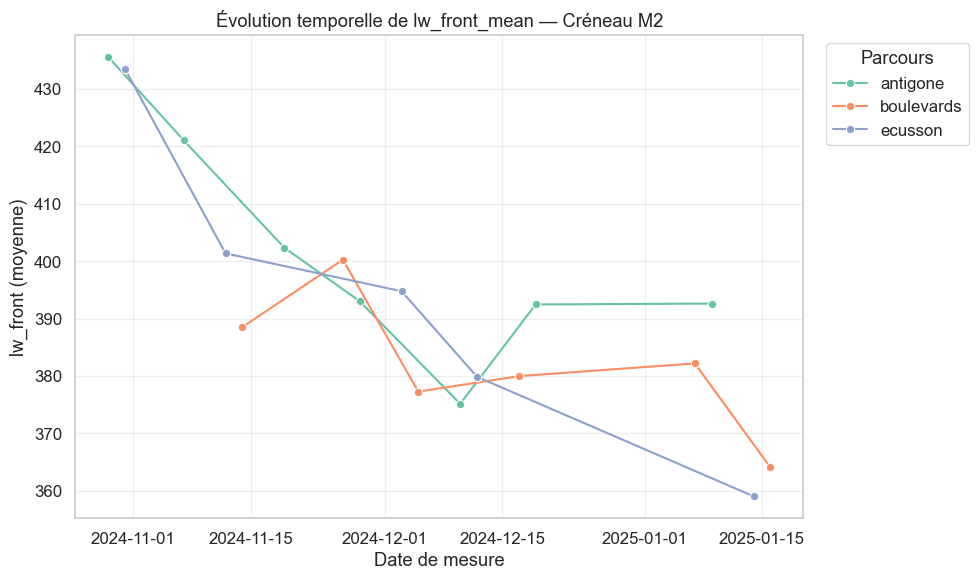

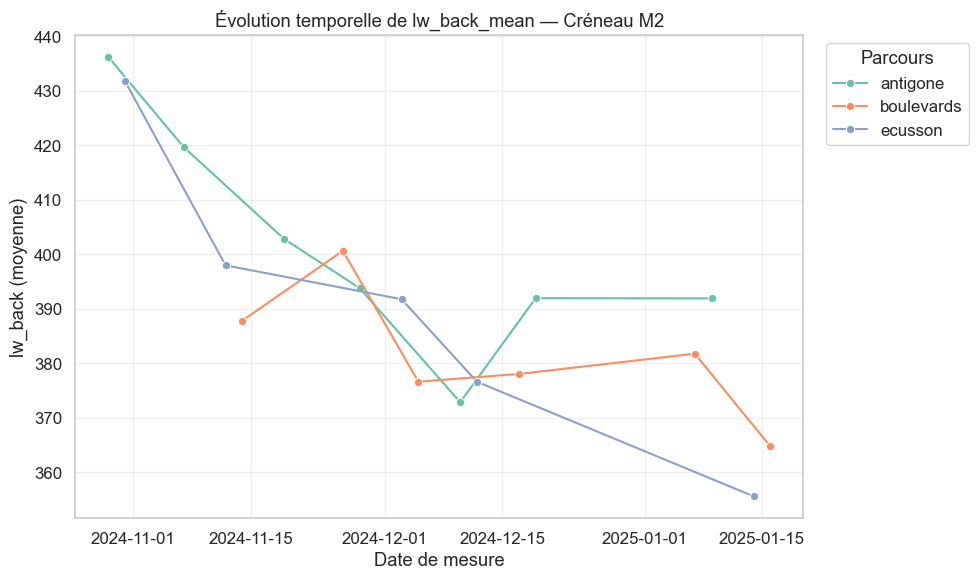

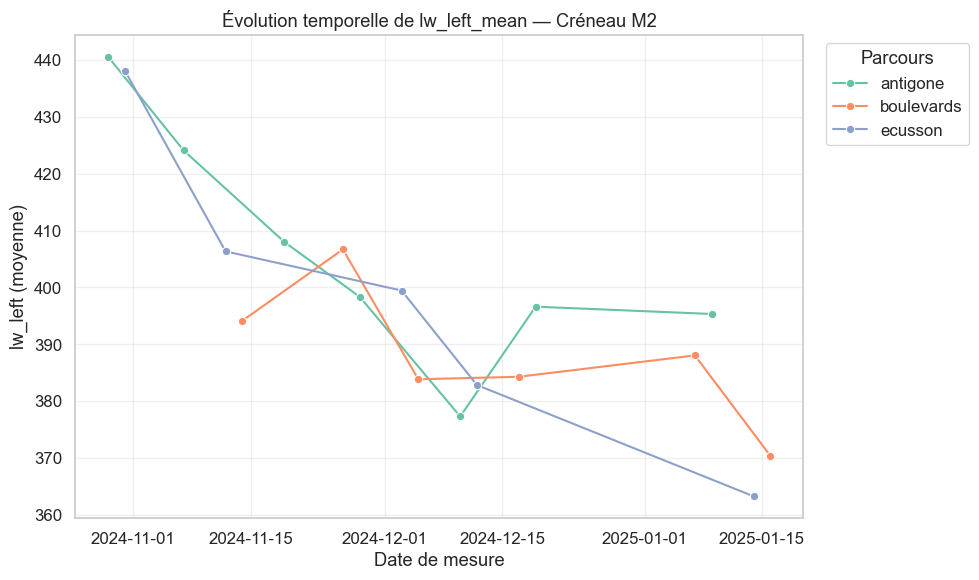

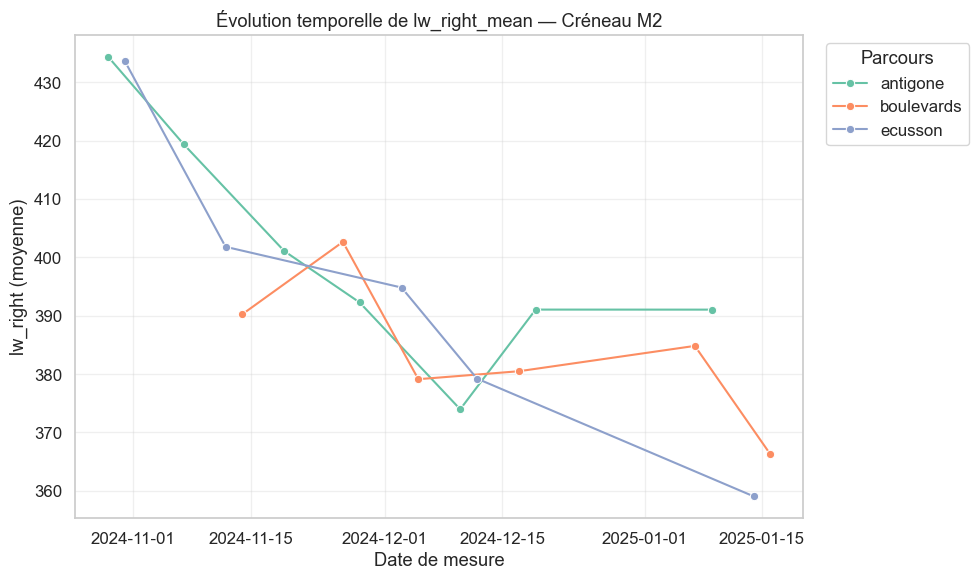

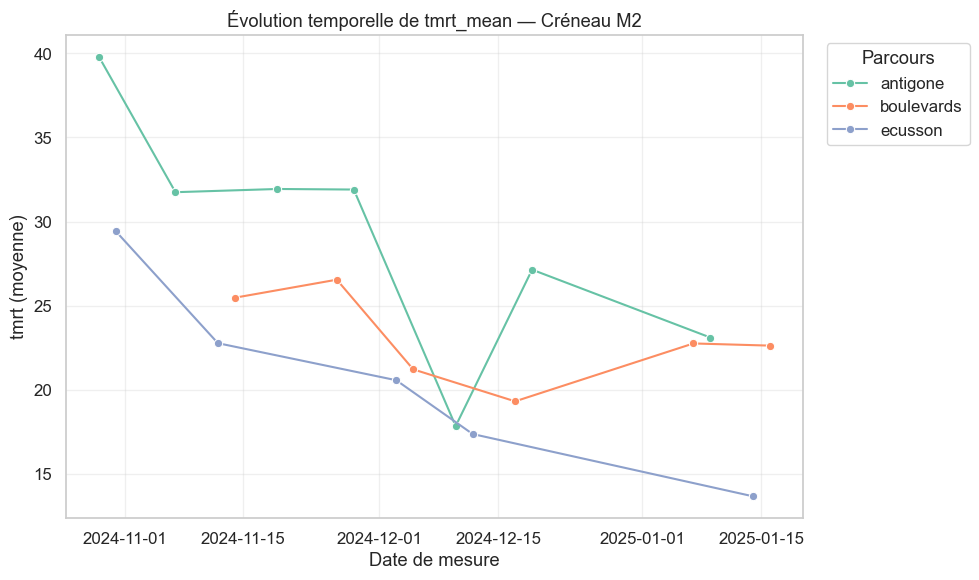

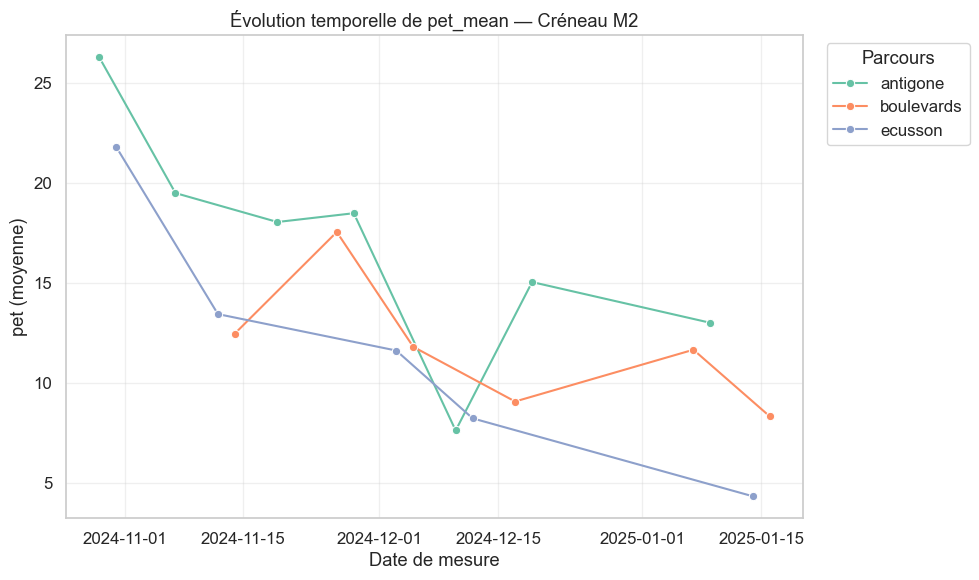

In [69]:
# Évolution temporelle — Créneau M2

# Charger le fichier agrégé
agg_file = Path("/Users/akkouh/Desktop/TER-Picopatt/outputs/aggregations/agg_par_passage.csv")
agg = pd.read_csv(agg_file)
agg["date"] = pd.to_datetime(agg["date"], errors="coerce")

# Filtrer sur le créneau M2
subset = agg[agg["M_slot"] == "M2"]

# Variables à tracer
vars_to_plot = [
    "tair_thermohygro_mean", "tair_tc1_mean", "tair_tc2_mean", "tair_anemo_mean",
    "rh_thermohygro_mean", "ws_mean", "wdir_mean",
    "sw_up_mean", "sw_front_mean", "sw_right_mean",
    "lw_up_mean", "lw_down_mean", "lw_front_mean", "lw_back_mean", "lw_left_mean", "lw_right_mean",
    "tmrt_mean", "pet_mean"
]

vars_to_plot = [v for v in vars_to_plot if v in subset.columns]
sns.set(style="whitegrid", font_scale=1.1)

for var in vars_to_plot:
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=subset,
        x="date",
        y=var,
        hue="track_id",
        marker="o",
        palette="Set2"
    )
    plt.title(f"Évolution temporelle de {var} — Créneau M2")
    plt.xlabel("Date de mesure")
    plt.ylabel(var.replace("_mean", " (moyenne)"))
    plt.legend(title="Parcours", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

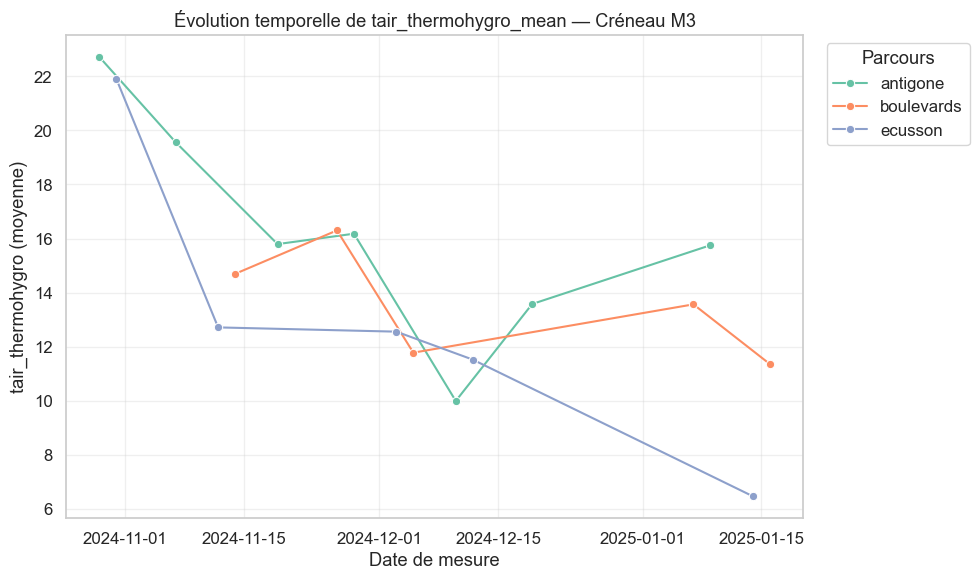

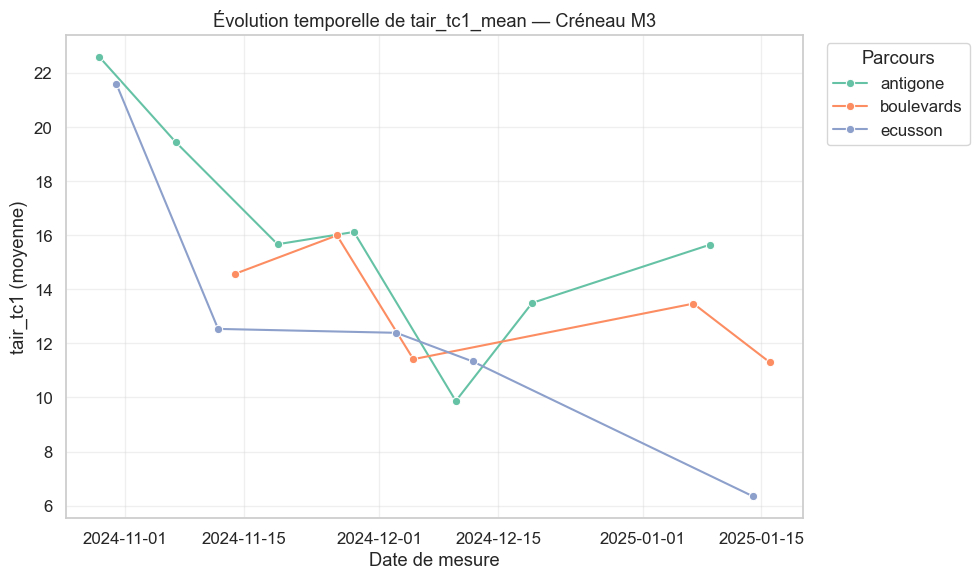

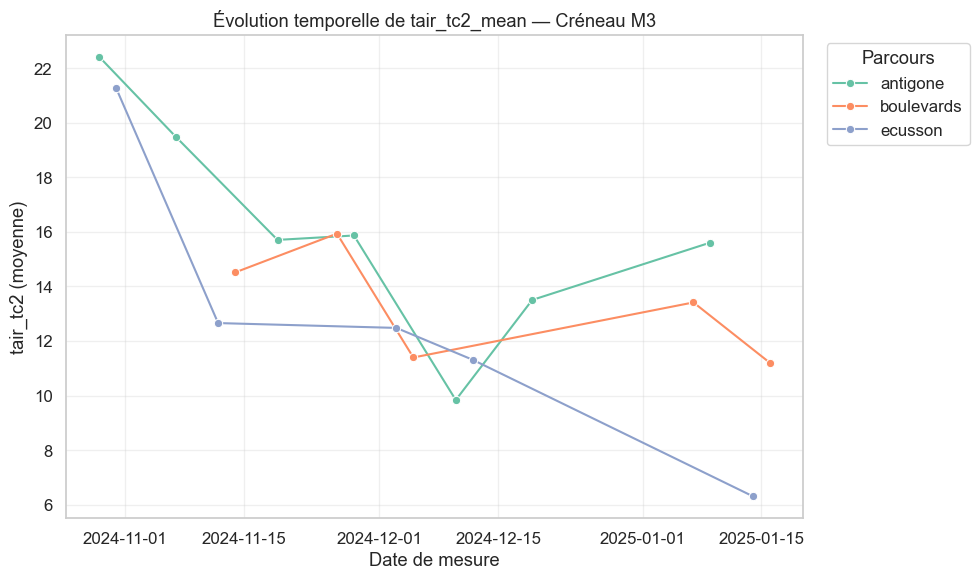

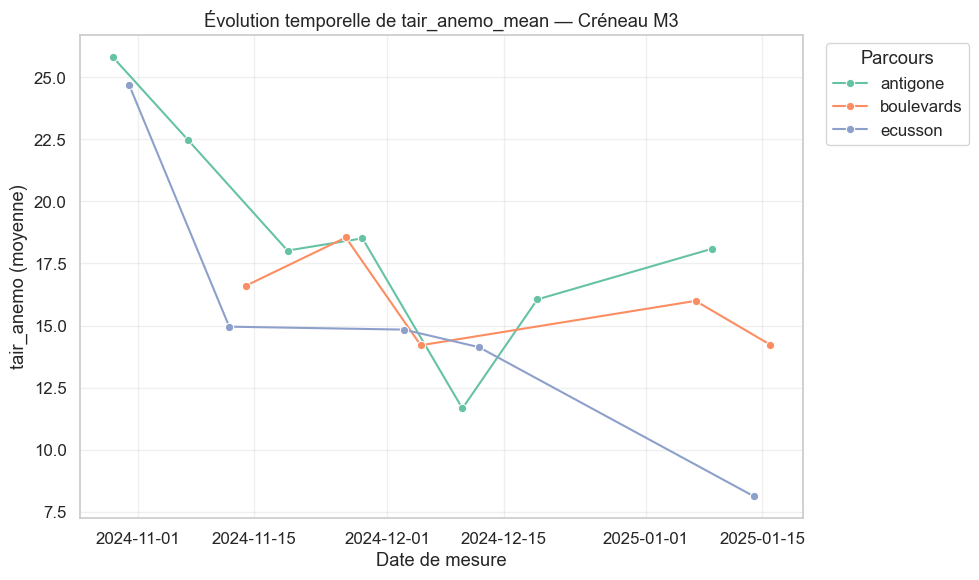

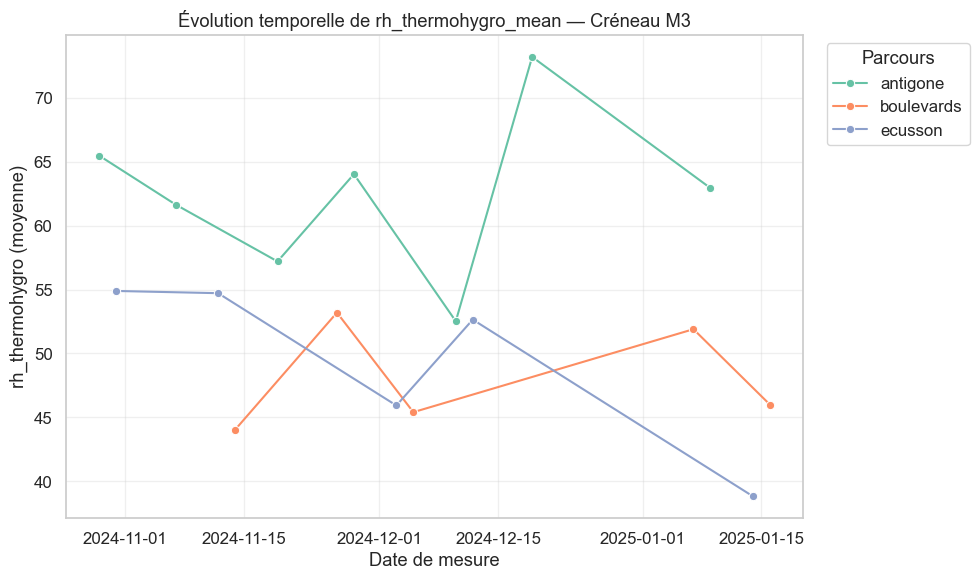

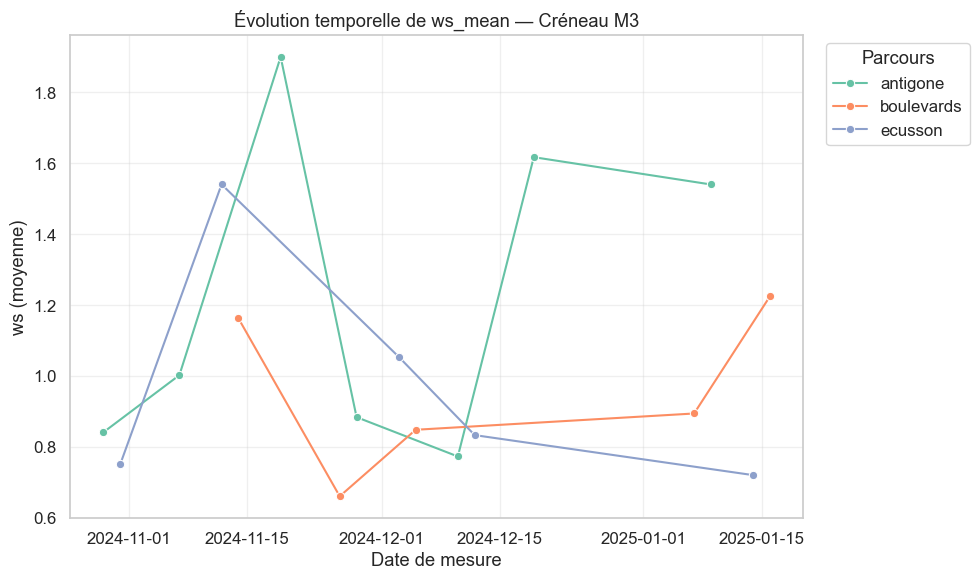

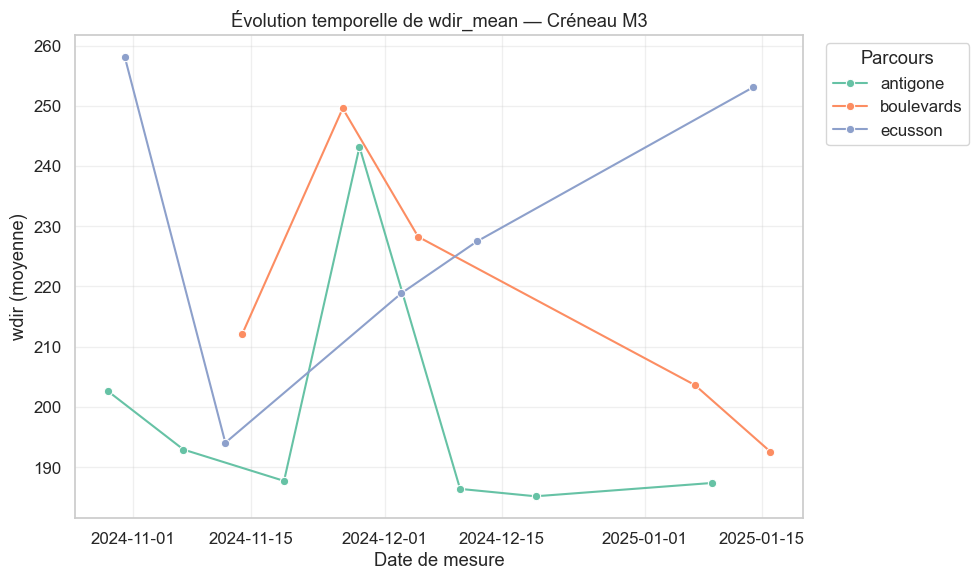

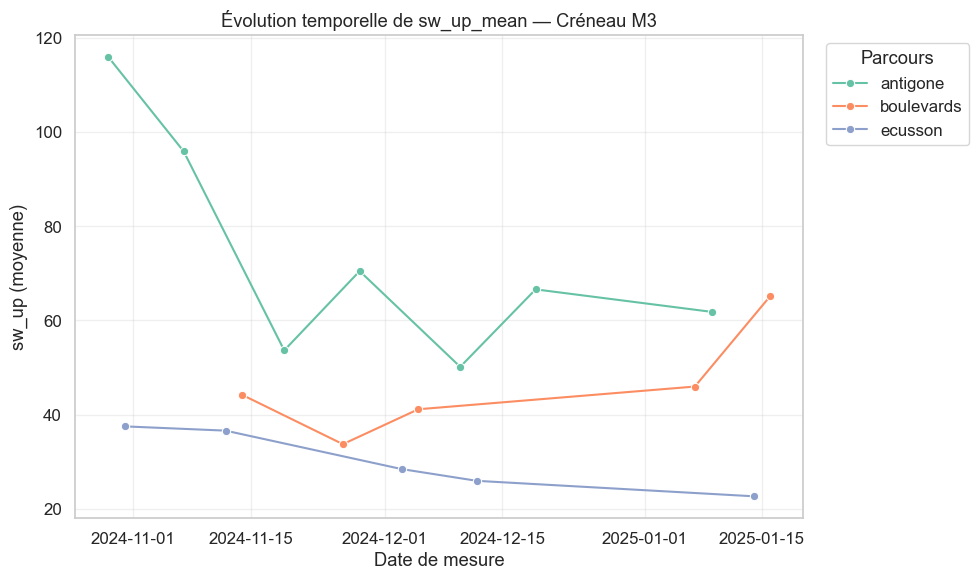

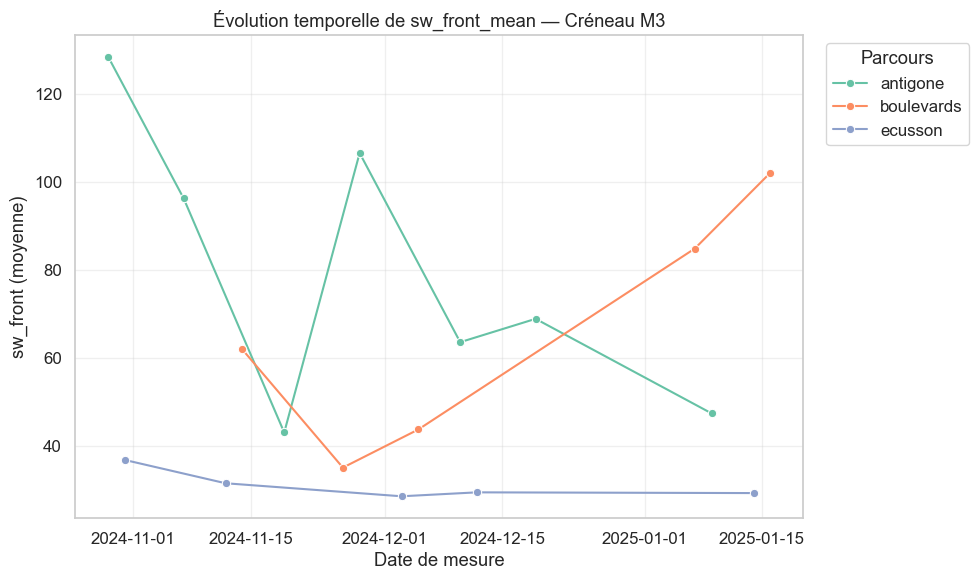

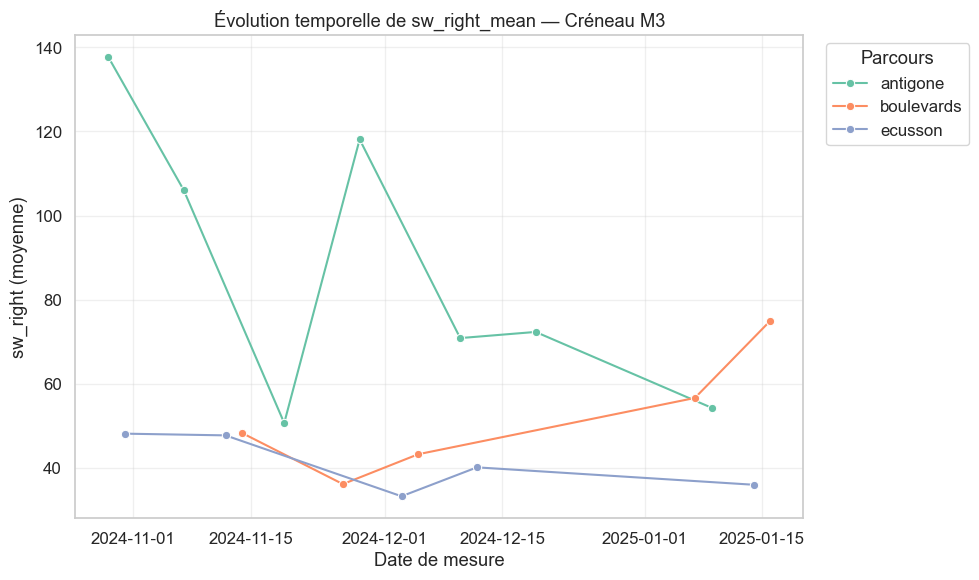

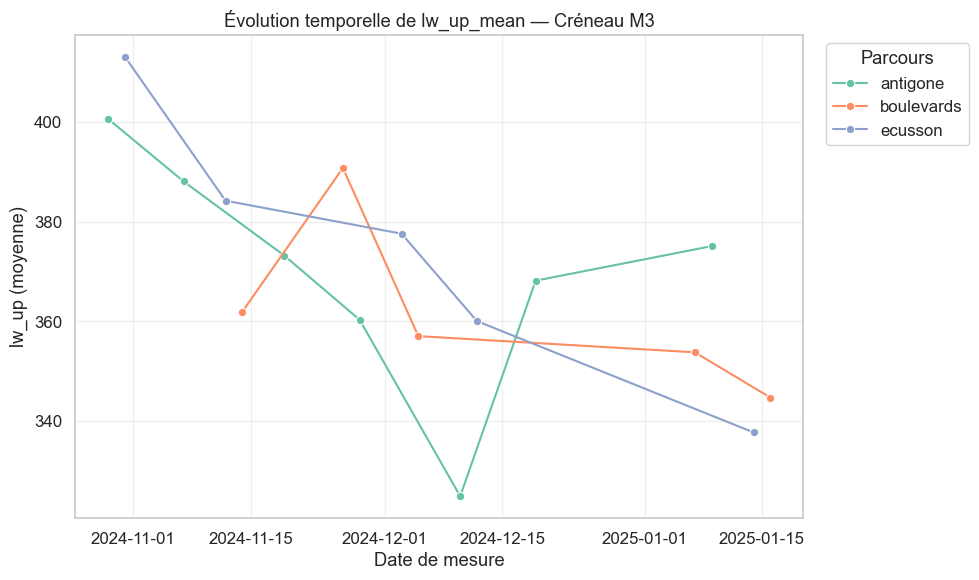

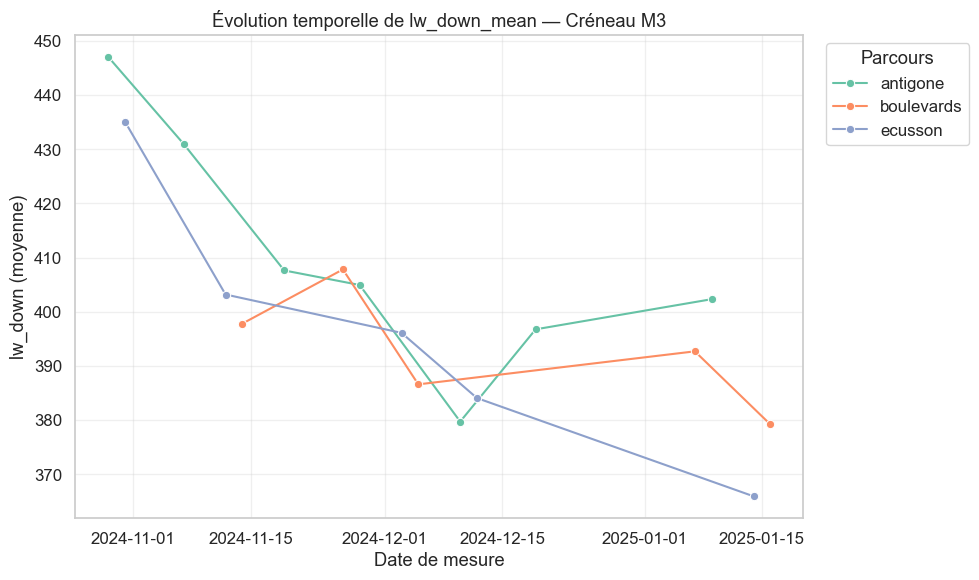

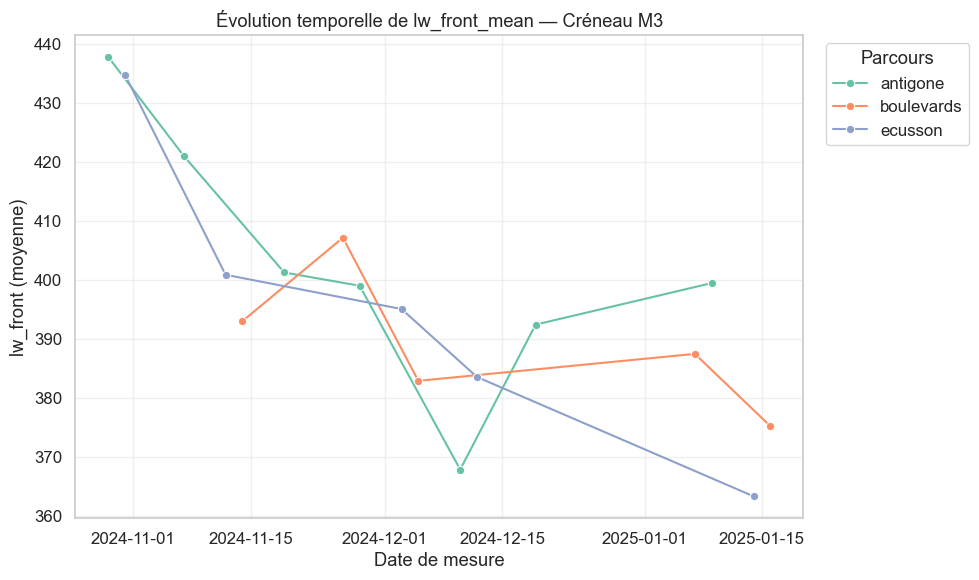

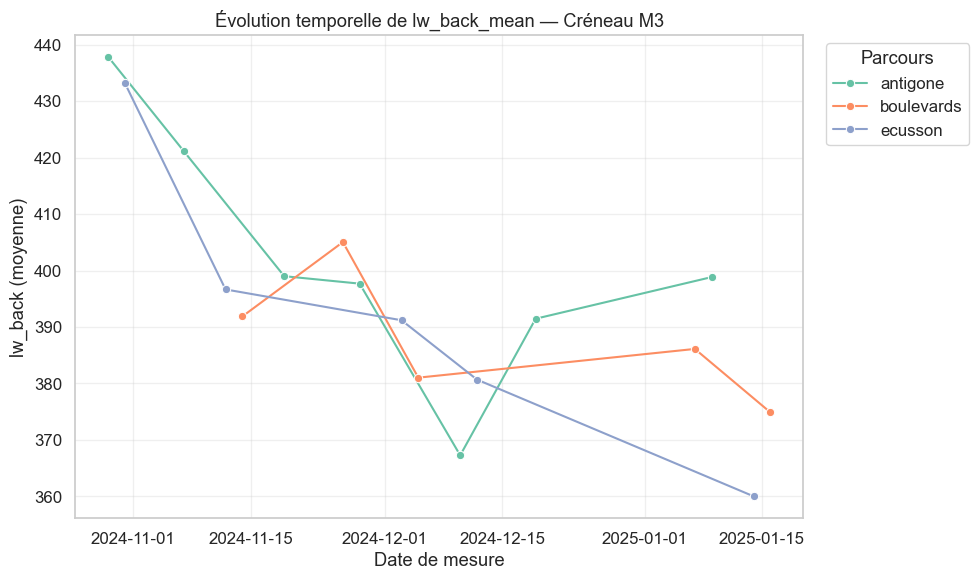

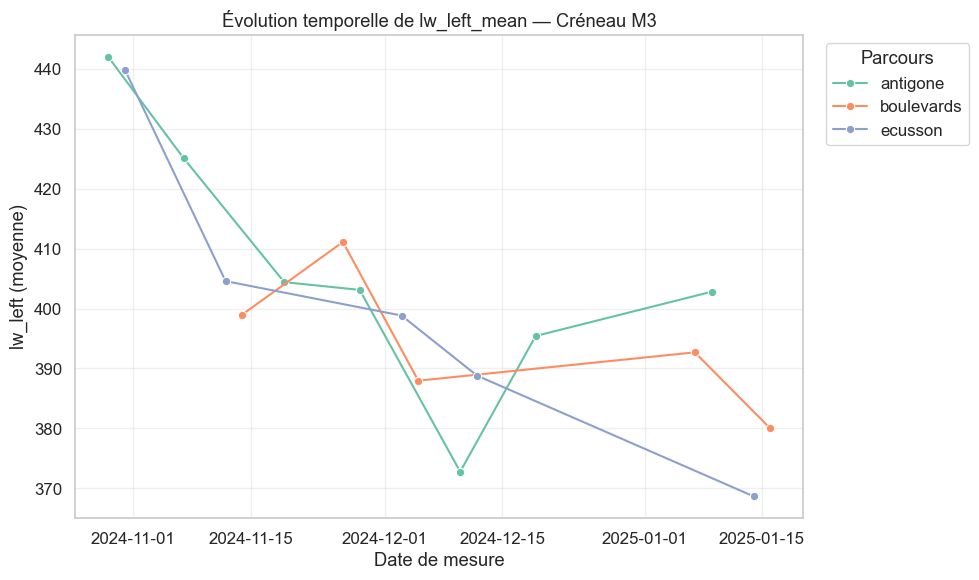

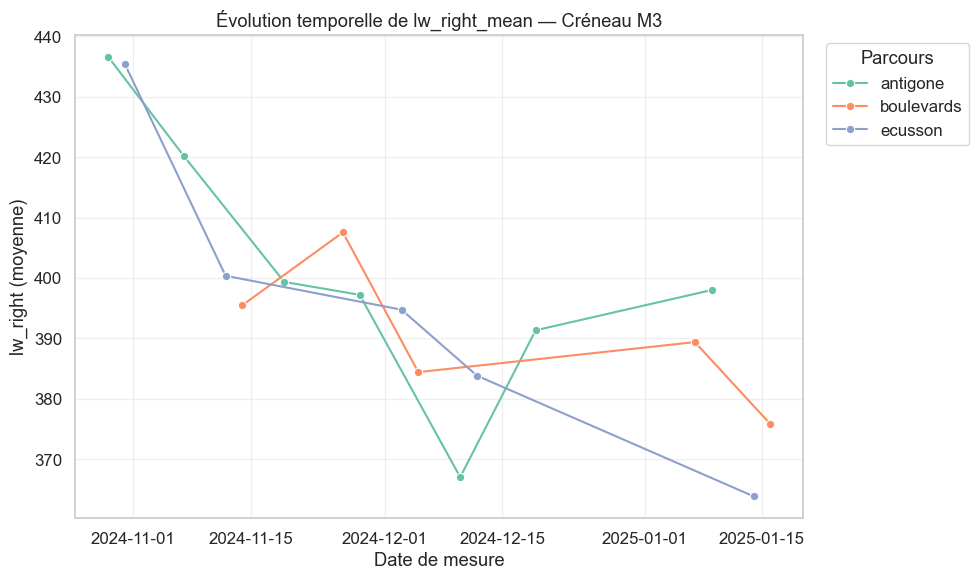

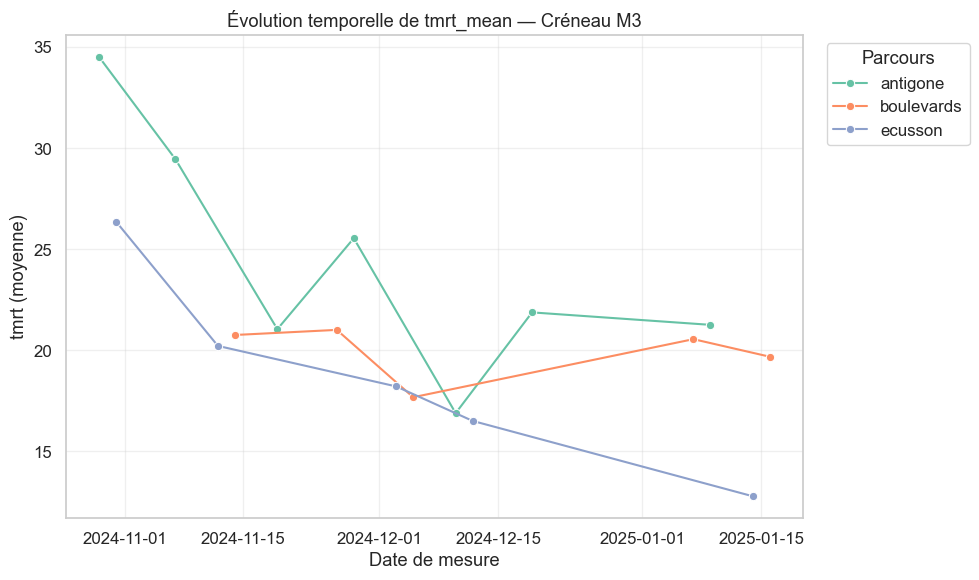

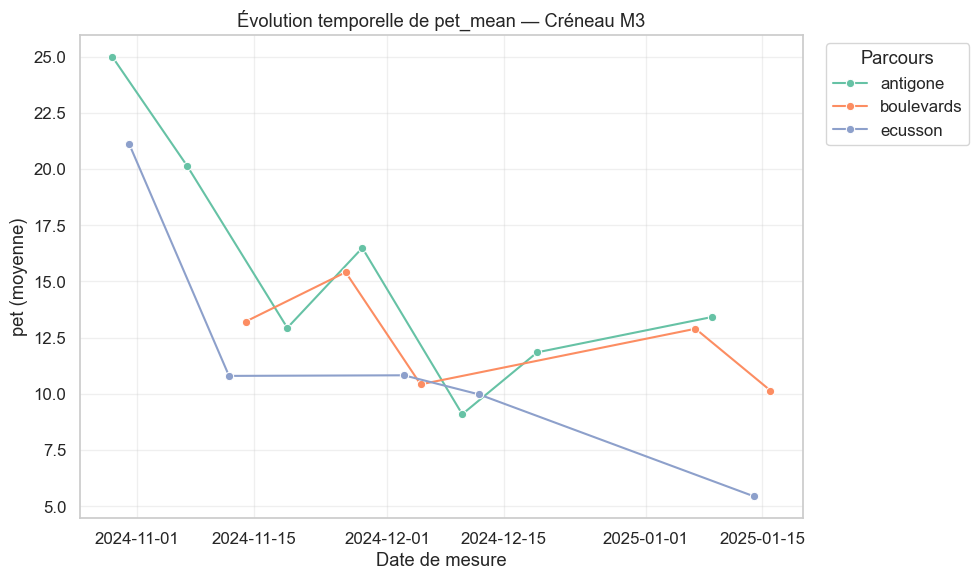

In [70]:
# Évolution temporelle — Créneau M3


subset = agg[agg["M_slot"] == "M3"]
vars_to_plot = [v for v in vars_to_plot if v in subset.columns]

for var in vars_to_plot:
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=subset,
        x="date",
        y=var,
        hue="track_id",
        marker="o",
        palette="Set2"
    )
    plt.title(f"Évolution temporelle de {var} — Créneau M3")
    plt.xlabel("Date de mesure")
    plt.ylabel(var.replace("_mean", " (moyenne)"))
    plt.legend(title="Parcours", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

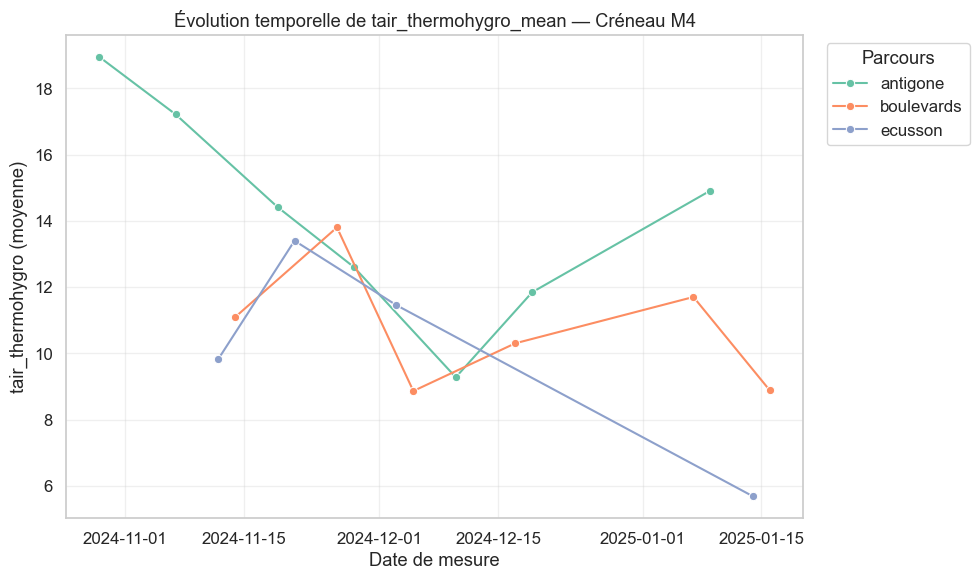

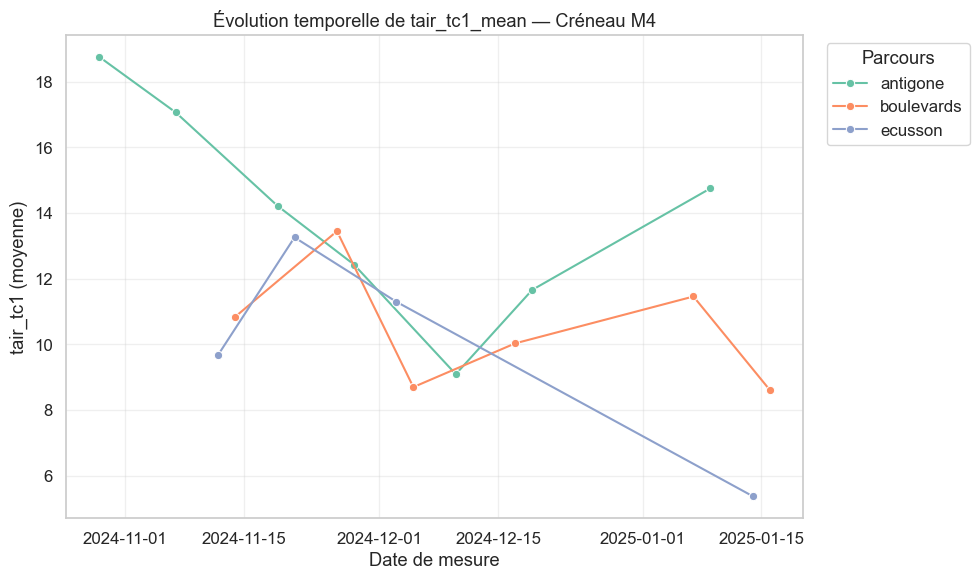

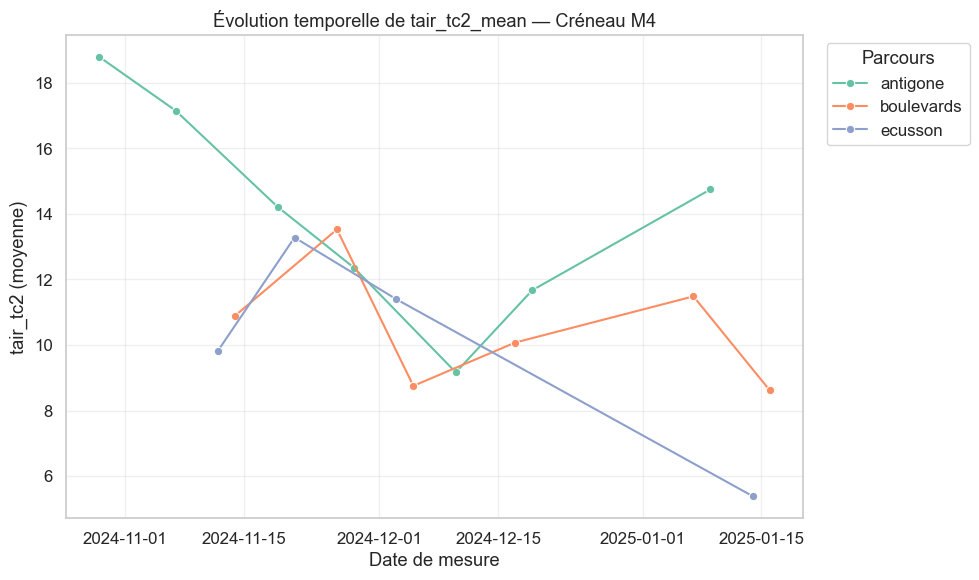

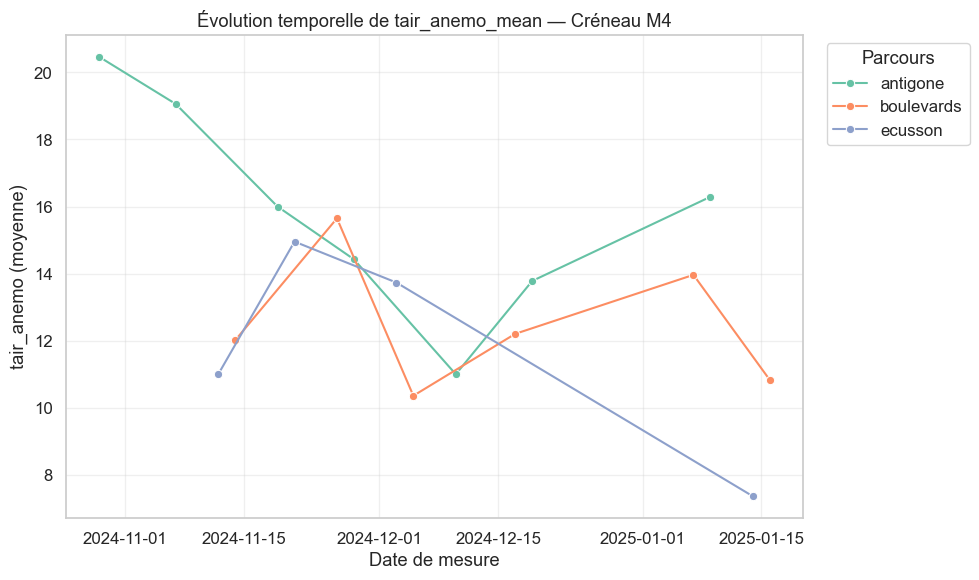

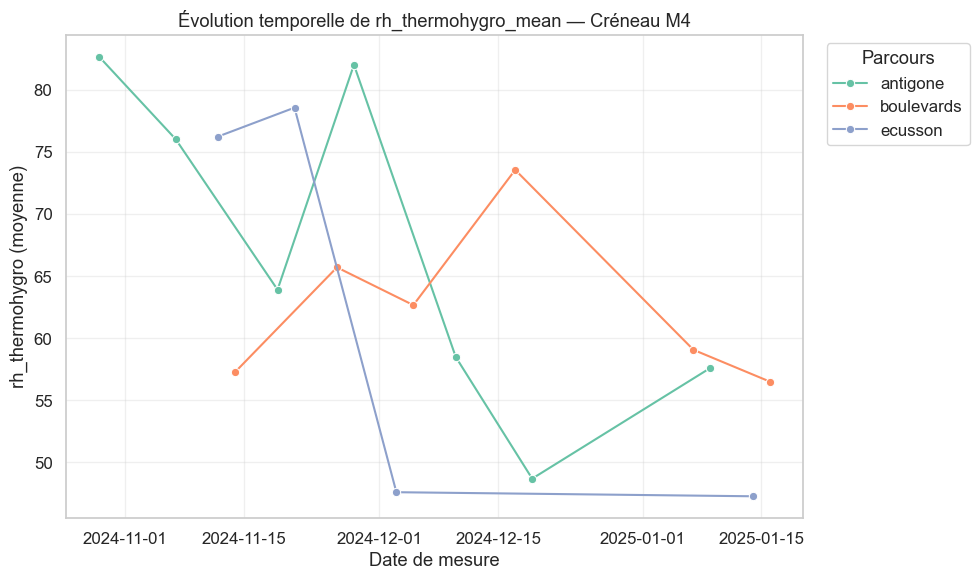

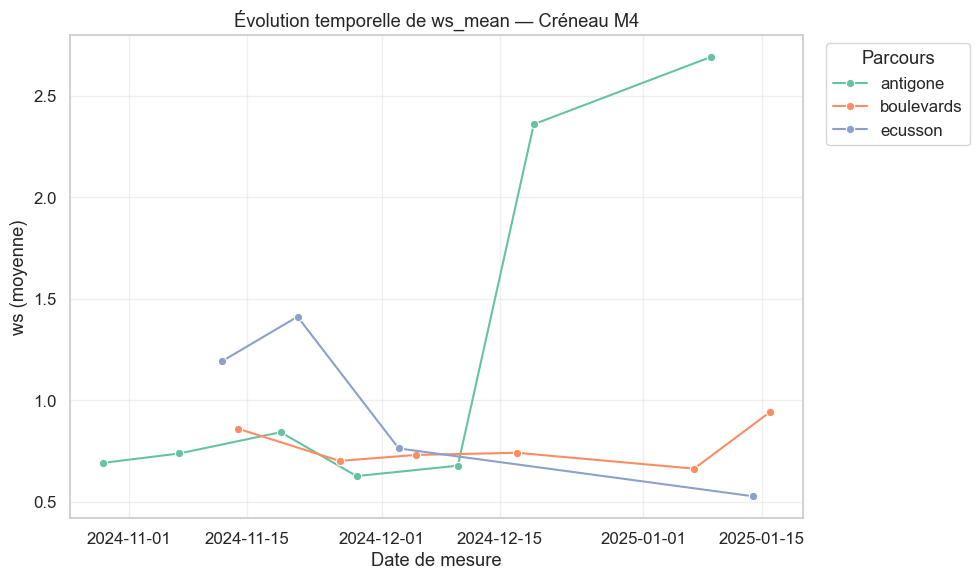

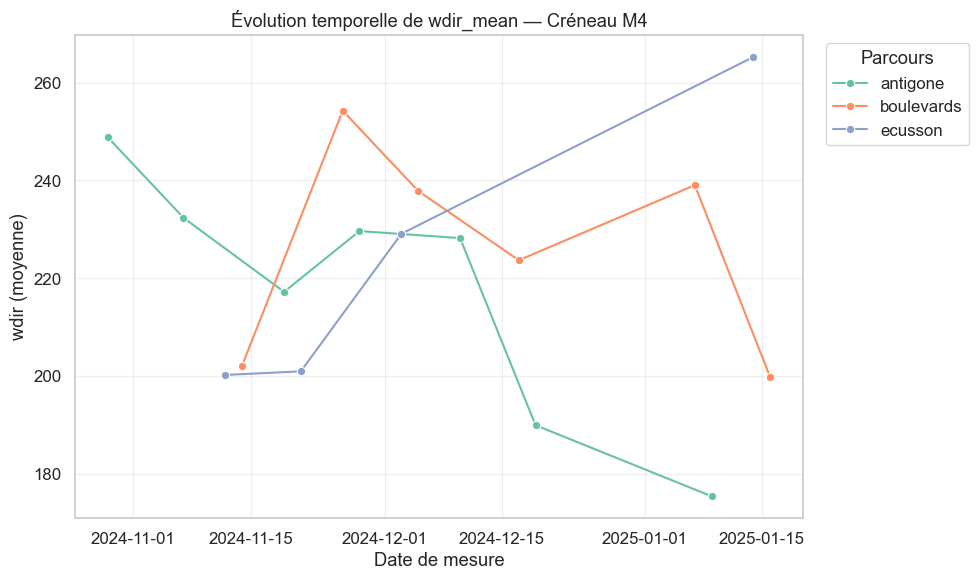

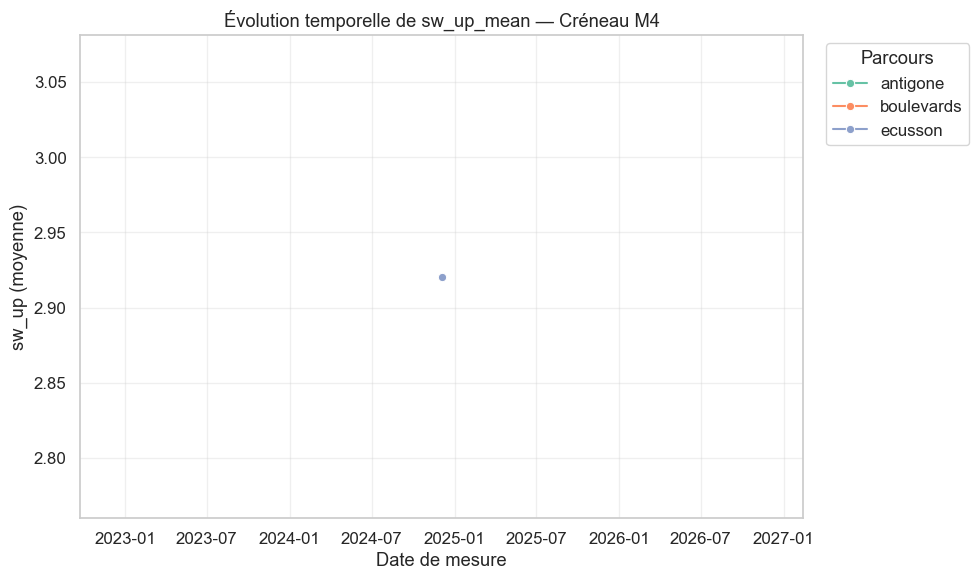

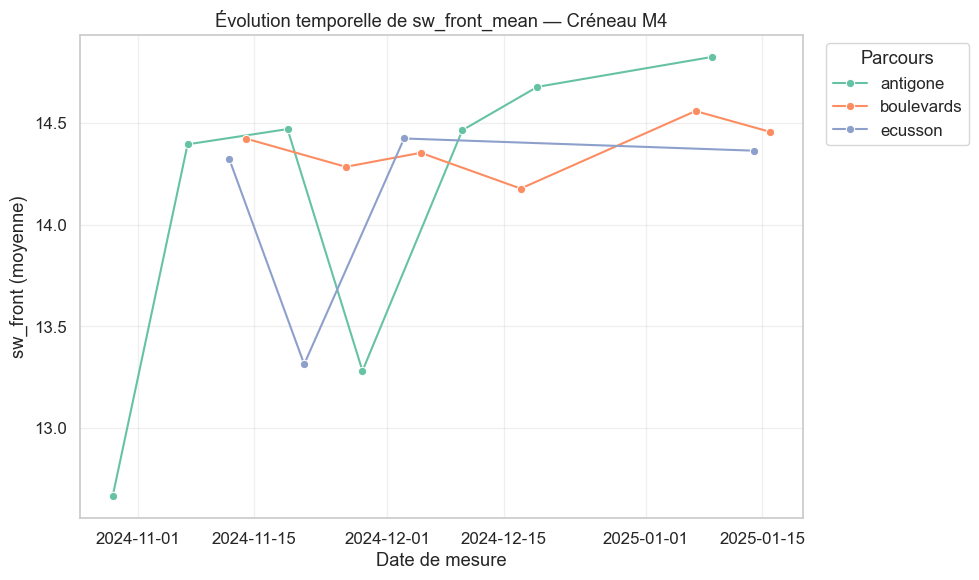

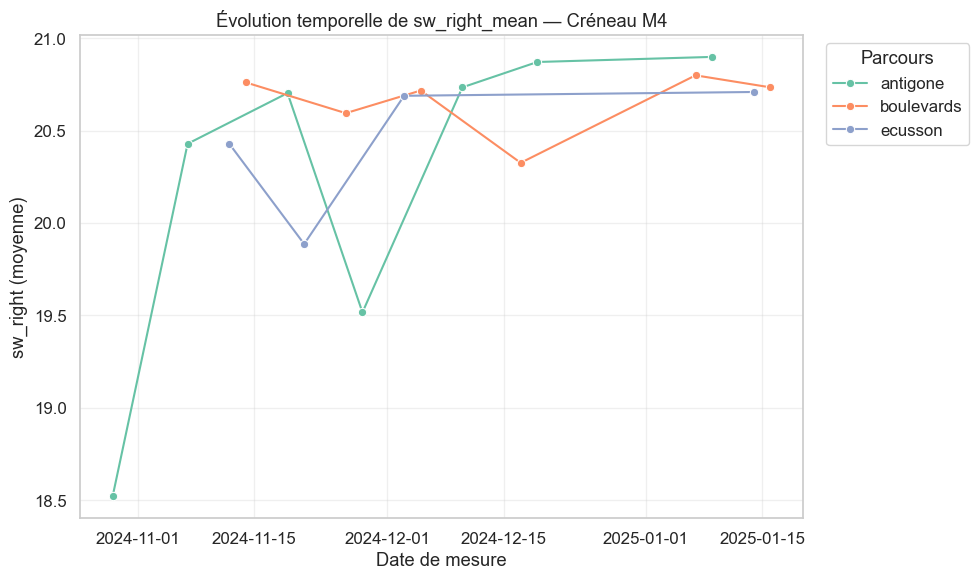

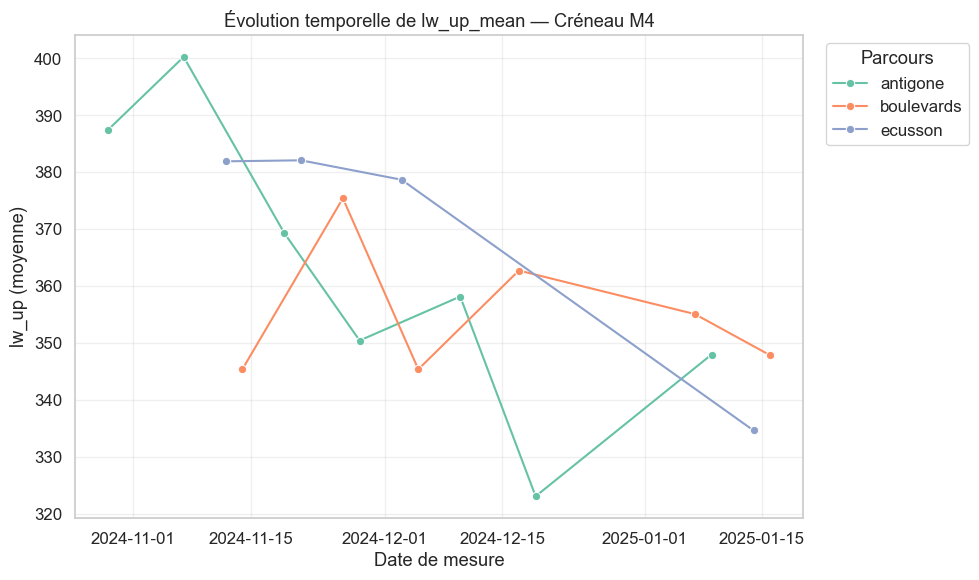

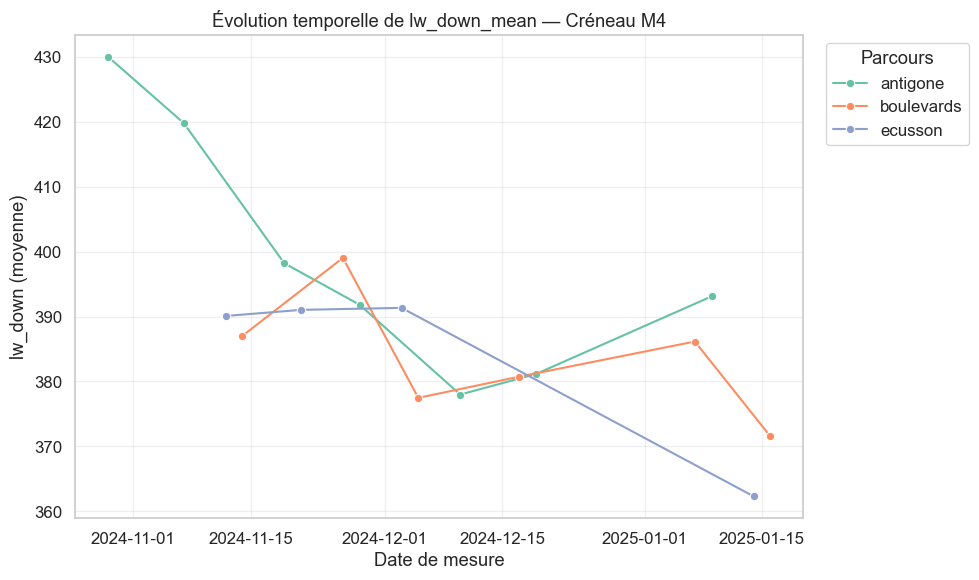

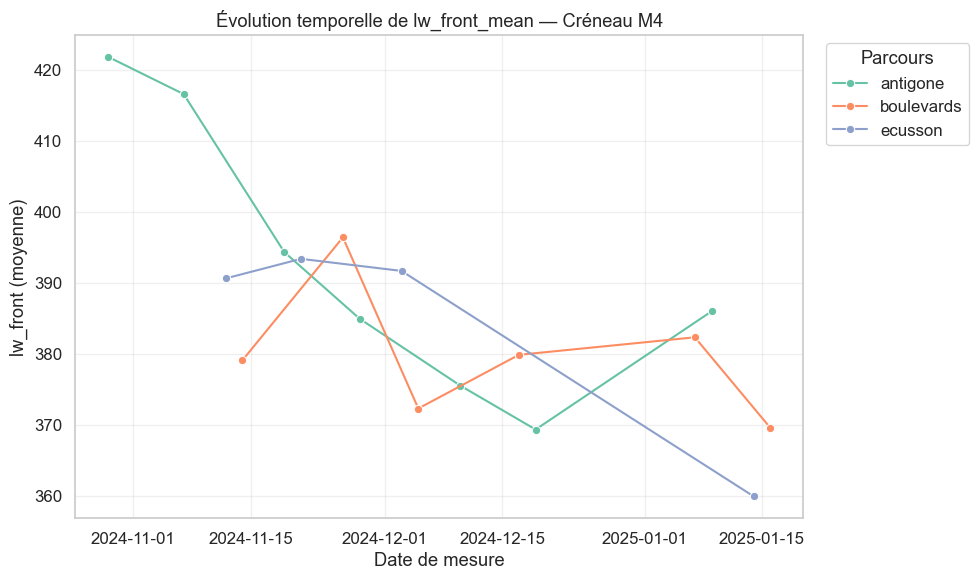

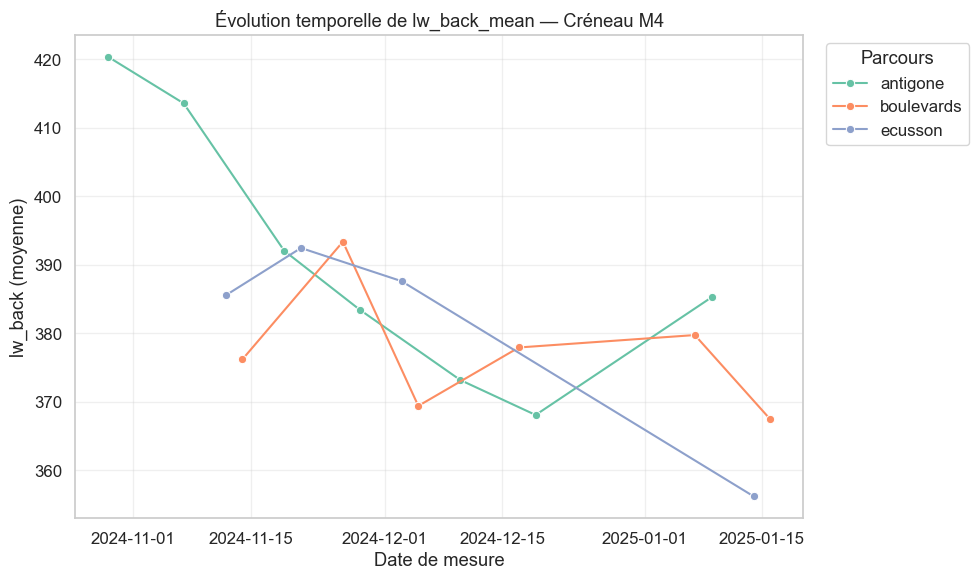

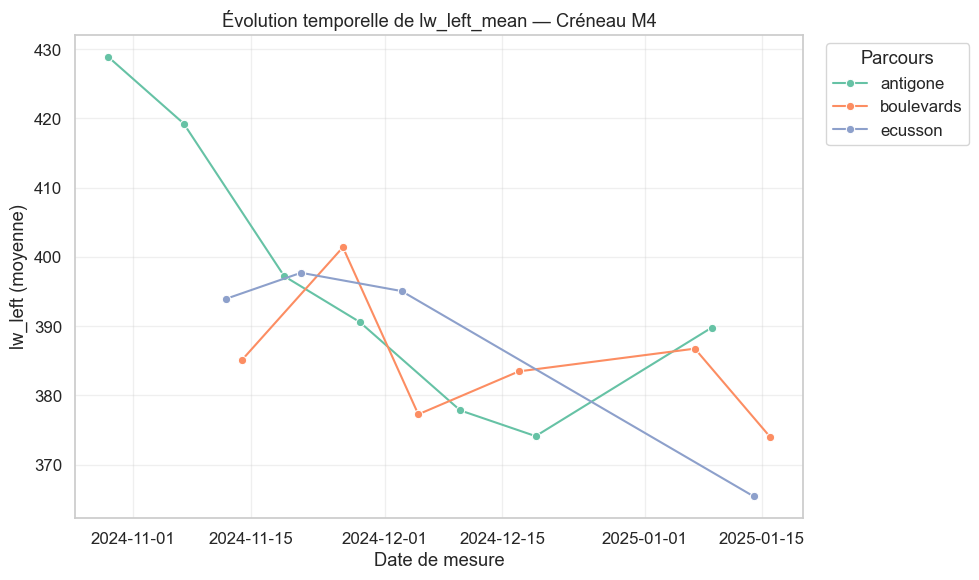

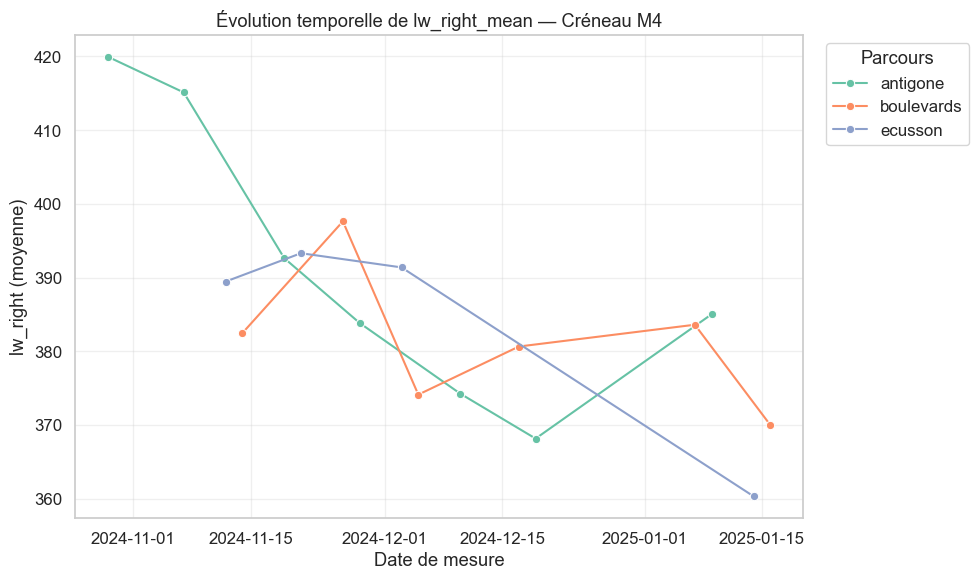

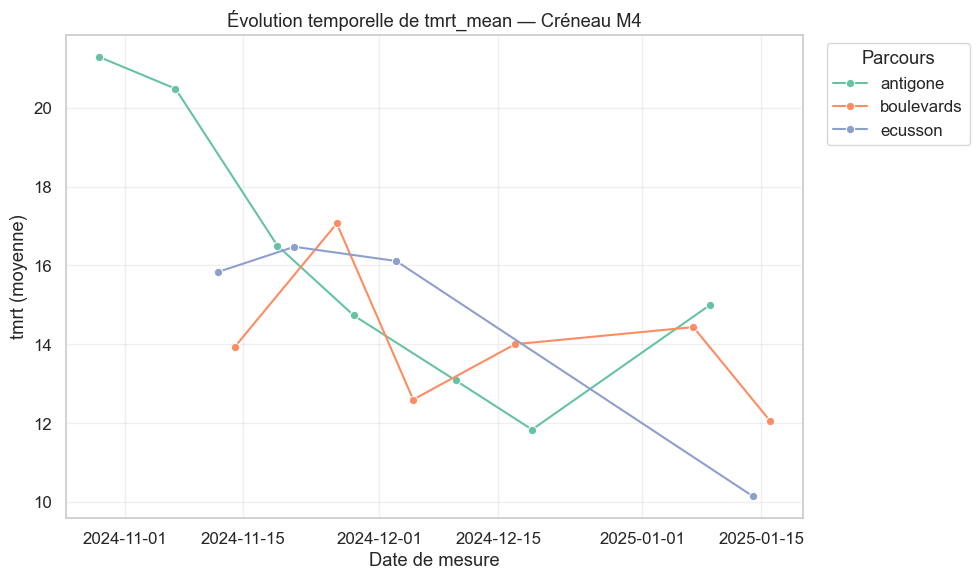

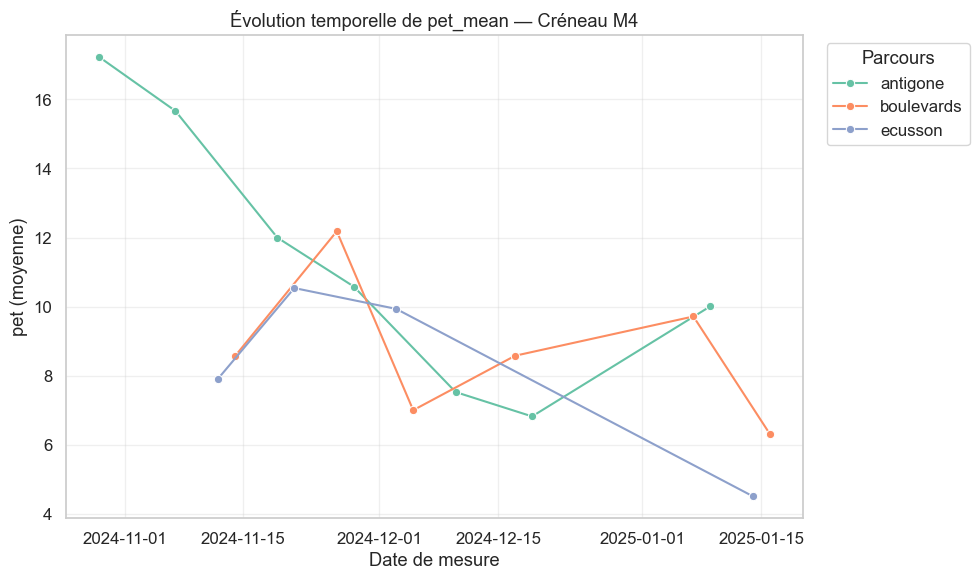

In [71]:
# Évolution temporelle — Créneau M4

subset = agg[agg["M_slot"] == "M4"]
vars_to_plot = [v for v in vars_to_plot if v in subset.columns]

for var in vars_to_plot:
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=subset,
        x="date",
        y=var,
        hue="track_id",
        marker="o",
        palette="Set2"
    )
    plt.title(f"Évolution temporelle de {var} — Créneau M4")
    plt.xlabel("Date de mesure")
    plt.ylabel(var.replace("_mean", " (moyenne)"))
    plt.legend(title="Parcours", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [5]:
# fichier source
f = "/Users/akkouh/Desktop/TER-Picopatt/outputs/clean_nozeros/picopatt_montpellier_ecusson_20250114_0832.csv"
df = pd.read_csv(f)

print(df.columns)

Index(['project_id', 'track_id', 'section_id', 'segment_id', 'point_id',
       'section_duration', 'section_speed', 'section_warning', 'gnss_accuracy',
       'section_weather', 'timestamp', 'lon_ontrack', 'lat_ontrack', 'lon_rtk',
       'lat_rtk', 'sun_azimuth', 'sun_height', 'tair_thermohygro', 'tair_tc1',
       'tair_tc2', 'tair_anemo', 'rh_thermohygro', 'ws', 'wdir', 'sw_up',
       'sw_front', 'sw_back', 'sw_right', 'lw_up', 'lw_down', 'lw_front',
       'lw_back', 'lw_left', 'lw_right', 'tmrt', 'pet', 'fichier_originaire',
       'date', 'M_slot'],
      dtype='object')


## Correction de l' aggregation

In [92]:
# Charger le fichier original 
f = "/Users/akkouh/Desktop/TER-Picopatt/outputs/clean_nozeros/picopatt_montpellier_ecusson_20250114_0832.csv"
df = pd.read_csv(f)

# Identifier les colonnes concernées
cols_to_clean = [c for c in df.columns if any(x in c.lower() for x in ["tair_tc1", "tair_tc2"])]

print(f"Colonnes détectées pour correction : {cols_to_clean}")

# Vérification avant correction
for col in cols_to_clean:
    print(f"\nAvant correction : {col} ")
    print(df[col].describe())

#  Correction : mise à NaN de toutes les valeurs suspectes
for col in cols_to_clean:
    df[col] = np.nan
    print(f" {col} : toutes les valeurs remplacées par NaN")

#  Création d’un nouveau fichier nettoyé 
f_clean = f.replace(".csv", "_clean.csv")
df.to_csv(f_clean, index=False)

print(f"\n Nouveau fichier créé : {f_clean}")

#  Vérification rapide après correction 
for col in cols_to_clean:
    print(f"\n Après correction : {col} ")
    print(df[col].describe())

Colonnes détectées pour correction : ['tair_tc1', 'tair_tc2']

Avant correction : tair_tc1 
count    5493.000000
mean      533.475474
std       885.569615
min         0.007812
25%         0.570312
50%         0.921875
75%      1992.164062
max      2047.992188
Name: tair_tc1, dtype: float64

Avant correction : tair_tc2 
count    4374.000000
mean      112.842666
std       460.869139
min         0.007812
25%         0.617188
50%         0.875000
75%         1.156250
max      2047.992188
Name: tair_tc2, dtype: float64
 tair_tc1 : toutes les valeurs remplacées par NaN
 tair_tc2 : toutes les valeurs remplacées par NaN

 Nouveau fichier créé : /Users/akkouh/Desktop/TER-Picopatt/outputs/clean_nozeros/picopatt_montpellier_ecusson_20250114_0832_clean.csv

 Après correction : tair_tc1 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: tair_tc1, dtype: float64

 Après correction : tair_tc2 
count    0.0
mean     NaN
std      NaN
min      